In [14]:
import os
os.environ['DEVELOPMENT'] = 'True'
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime

from aquacrop import AquaCropModel, Soil, Crop, InitialWaterContent, IrrigationManagement, GroundWater, FieldMngt
from aquacrop.utils import prepare_weather, get_filepath



# Remaining mismatches

Currently all comparisons between AQ-Py and AQ-Win match well apart from:

* 7.7 - Deficit irrigation schedule - likely error with my Py schedule specification
* 8 - Slight mismatches throughout, nothing major

## Setup comparison function

In [15]:
# drop rows that contain repetitions of the headers throughout the file, one per successive annual run
def remove_headers(data):
    start_points=data[data.isin(['Day']).any(axis=1)].index # begin row drops where 'Day' is in any col
    end_points = [x+3 for x in start_points] # end 3 lines later
    to_drop=[]
    n=0

    while(n < len(start_points)):
        x=list(range(start_points[n]-1, end_points[n]-1)) # adjust drops, one line before the indexes found previously
        to_drop.extend(x) # add all indexes to drop to a list
        n=n+1

    new_data = data.drop(index=to_drop)

    return new_data

In [16]:
def extract_py_data(py_model):
    py_growth=py_model.get_crop_growth()
    py_wflux=py_model.get_water_flux()
    #py_wstorage=py_model.get_water_storage()

    start_year=py_model.sim_start_time.split('/')[0]
    start_month,start_day=py_model.crop.planting_date.split('/')

    py_growth['datetime']=py_growth.apply(lambda x:datetime.datetime(int(x['season_counter']+int(start_year)),int(start_month),int(start_day)+1)+datetime.timedelta(int(x['dap']-1)),axis=1)
    py_wflux['datetime']=py_wflux.apply(lambda x:datetime.datetime(int(x['season_counter']+int(start_year)),int(start_month),int(start_day)+1)+datetime.timedelta(int(x['dap']-1)),axis=1)

    py_growth.drop(['dap','time_step_counter','season_counter'], inplace=True,axis=1)
    py_wflux.drop(['dap','time_step_counter','season_counter'], inplace=True,axis=1)

    py_outputs=pd.merge(py_growth, py_wflux, on='datetime')
    py_outputs['source']='AQ-Py'
    py_outputs.rename(columns={
            'yield_': 'dry_yield',
            # 'Month': 'month',
            # 'Day': 'day',
            },
            inplace=True, 
            errors='raise')

    return py_outputs

    

In [17]:
def extract_win_data(proj_name):

    file_list=['Crop','Wabal','Prof','Clim'] # ,'CompWC'
    data=[]

    for i in range(0,len(file_list)):
        file_type=file_list[i]
        path='C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+proj_name+file_type+'.OUT'
        if file_type=='Crop':
            temp=pd.read_csv(path,delim_whitespace=True,encoding="ISO-8859-1", skiprows=4, skipfooter=33)
        elif file_type=='Wabal':
            temp=pd.read_csv(path,delim_whitespace=True,encoding="ISO-8859-1", skiprows=4, skipfooter=27)
            temp=temp.drop(['Tr', 'Trx','Tr/Trx', 'WCTot','Rain'],axis=1)
        elif file_type=='Prof':
            temp=pd.read_csv(path,delim_whitespace=True,encoding="ISO-8859-1", skiprows=4, skipfooter=19, index_col=False)
            temp=temp.drop(['Z'],axis=1)
        #elif file_type=='CompWC':
        #    temp=pd.read_csv(path,delim_whitespace=True,encoding="ISO-8859-1", skiprows=5, skipfooter=9)
        elif file_type=='Clim':
            temp=pd.read_csv(path,delim_whitespace=True,encoding="ISO-8859-1", skiprows=4, skipfooter=15)
        
        #if file_type != 'CompWC':
        temp=temp.drop([0])
        
        temp.rename(columns={
            'Year': 'year',
            'Month': 'month',
            'Day': 'day',
            },
            inplace=True, 
            errors='raise'
        )
        temp=remove_headers(temp)
        # add datetime column
        temp['datetime'] = pd.to_datetime(temp[['year','month','day']])
        # convert all cols except date-related cols to floats
        cols=temp.columns.drop(['day','month','year','datetime'])
        temp[cols]=temp[cols].apply(pd.to_numeric, errors='coerce')
        temp=temp.drop(['year','month','day','DAP','Stage'], axis=1)
        data.append(temp)

    temp1=pd.merge(data[0],data[1], on='datetime')
    temp2=pd.merge(temp1,data[2], on='datetime')
    win_data=pd.merge(temp2,data[3], on='datetime')
    #win_data=pd.merge(temp3,data[4], on='datetime')   
    
    # rename cols to align with py col names
    win_data.rename(columns={'CC': 'canopy_cover',
                            'Y(dry)': 'dry_yield',
                            'Biomass': 'biomass',
                            'HI':'harvest_index',
                            'Z':'z_root',
                            },
                    inplace=True, errors='raise'
                    )
    win_data['harvest_index']=win_data['harvest_index']/100
    win_data['canopy_cover']=win_data['canopy_cover']/100
    win_data['biomass']=win_data['biomass']*100
    
    win_data['source']='AQ-Win'

    return win_data
    # Crop: daily crop growth: 4, 33

    # Wabal: daily water balance: 4,27

    # Prof: daily soil-water content in soil profile (WC) and root zone (Wr): 4,19

    # CompWC: daily soil-water content at various depths: 4,9

    # Clim: climate input data: 4,15

In [22]:
def run_comparison(win_filename, py_model):

    # Get Python daily output
    py_daily_outputs = py_model.get_crop_growth()
    py_daily_outputs['biomass']=py_daily_outputs['biomass']/100
    py_daily_outputs['canopy_cover']=py_daily_outputs['canopy_cover']*100
    py_daily_outputs['dap']=py_daily_outputs['dap'].astype(int)

    start_year=py_model.sim_start_time.split('/')[0]
    start_month,start_day=py_model.crop.planting_date.split('/')
    
    py_daily_outputs['datetime']=py_daily_outputs.apply(lambda x:datetime.datetime(int(x['season_counter']+int(start_year)),int(start_month),int(start_day)+1)+datetime.timedelta(int(x['dap']-1)),axis=1)
    py_daily_outputs['year']=pd.DatetimeIndex(py_daily_outputs['datetime']).year
    py_daily_outputs['month']=pd.DatetimeIndex(py_daily_outputs['datetime']).month
    py_daily_outputs['day']=pd.DatetimeIndex(py_daily_outputs['datetime']).day
    py_daily_outputs['source']='AQ-Py'

    # Get Python annual outputs
    py_annual_outputs = py_model._outputs.final_stats.round(3)
    py_annual_outputs.columns = ["Season","CropType","datetime","HarvestDate (Step)","dry_yield", "fresh_yield","yield_potential", "Seasonal irrigation (mm)"]
    #py_annual_outputs.columns = ["Season","CropType","datetime","HarvestDate (Step)","dry_yield", "Seasonal irrigation (mm)"]
    py_annual_outputs['source']='Py'


    # Get windows daily outputs
    win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT', 
                            skiprows=4, skipfooter=33,  delim_whitespace=True,encoding="latin1")
    win_daily_outputs=win_daily_outputs.drop([0])
    win_daily_outputs.rename(columns={
        'Year': 'year',
        'Month': 'month',
        'Day': 'day',
        },
        inplace=True, 
        errors='raise')

    win_daily_outputs=remove_headers(win_daily_outputs)
    # add datetime column
    win_daily_outputs['datetime'] = pd.to_datetime(win_daily_outputs[['year','month','day']])
    # convert all cols except date-related cols to floats
    win_daily_outputs['CC']=win_daily_outputs['CC'].astype(float)
    cols=win_daily_outputs.columns.drop(['day','month','year','datetime'])
    win_daily_outputs[cols]=win_daily_outputs[cols].apply(pd.to_numeric, errors='coerce')
    # rename cols to align with py col names
    win_daily_outputs.rename(columns={'CC': 'canopy_cover',
                                'Y(dry)': 'Yield',
                                'Biomass': 'biomass',
                                'HI':'harvest_index',
                                },
                    inplace=True, errors='raise')
    win_daily_outputs['harvest_index']=win_daily_outputs['harvest_index']/100
    win_daily_outputs['source']='AQ-Win'
    win_daily_outputs.to_csv('win-outputs.csv', index = False, encoding='utf-8')

    # Get windows annual outputs
    win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT', 
                                skiprows=4, skipfooter=8,  delim_whitespace=True,encoding="ISO-8859-1")
    win_annual_outputs=win_annual_outputs.drop([0])
    win_annual_outputs=remove_headers(win_annual_outputs)
    win_annual_outputs = win_annual_outputs.iloc[: , :-5] # remove 5 blank cols due to reading error
    win_annual_outputs['datetime']=pd.to_datetime(win_annual_outputs[['Year','Month','Day']])
    win_annual_outputs.columns=['Nr','Day','Month','Year','biomass','dry_yield','fresh-yield', 'datetime']
    win_annual_outputs=win_annual_outputs[win_annual_outputs['Nr'] != '0'] # remove blank rows
    win_annual_outputs['source']='Win'

    # Combine annual outputs
    combined_annual=pd.concat([win_annual_outputs, py_annual_outputs])
    combined_annual['dry_yield']=combined_annual['dry_yield'].astype(float)

    # Combine daily outputs
    both_daily_outputs=pd.concat([win_daily_outputs, py_daily_outputs])

    g1=sns.lineplot(data=both_daily_outputs, x='datetime',y='canopy_cover', hue='source')
    sns.move_legend(g1, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
    plt.show()
    #g.set_yticks(range(0,110,10), labels=range(0,110,10)) 
    g2=sns.lineplot(data=both_daily_outputs, x='datetime',y='biomass', hue='source')
    sns.move_legend(g2, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
    plt.show()
    g2b=sns.lineplot(data=both_daily_outputs, x='datetime',y='harvest_index', hue='source')
    sns.move_legend(g2b, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
    plt.show()
    g3=sns.lineplot(data=combined_annual.reset_index(), x='datetime', y='dry_yield', hue='source')
    sns.move_legend(g3, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
    plt.show()
    
    #all_daily_outputs=[py_model.get_crop_growth(), py_model.get_water_flux(), py_model.get_water_storage(), win_daily_outputs]

    #return all_daily_outputs

# Exercise 7

## Exercise 7.1 with Tunis Local soil

c:\Users\s10034cb\AppData\Local\anaconda3\envs\aquacrop-v7-improvements\lib\site-packages\aquacrop\solution\HIadj_pre_anthesis.py:51: RuntimeWarning: invalid value encountered in double_scalars
  Br = NewCond_B / NewCond_B_NS
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20588\1651980893.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20588\1651980893.py:56: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCrop

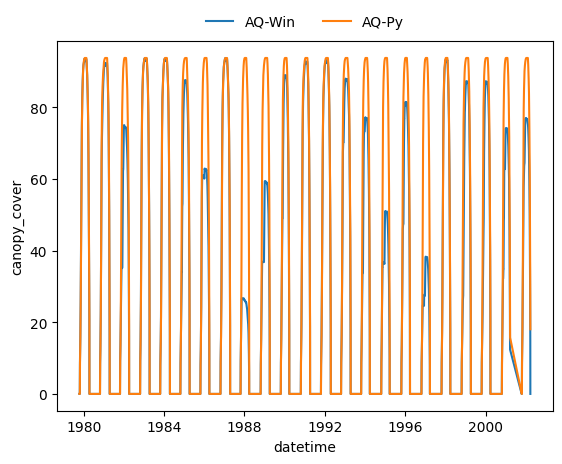

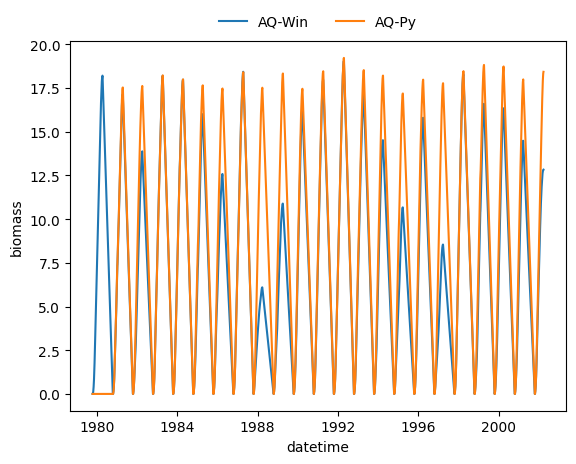

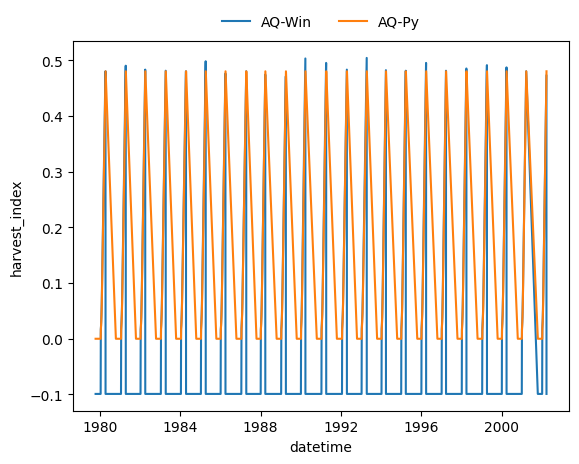

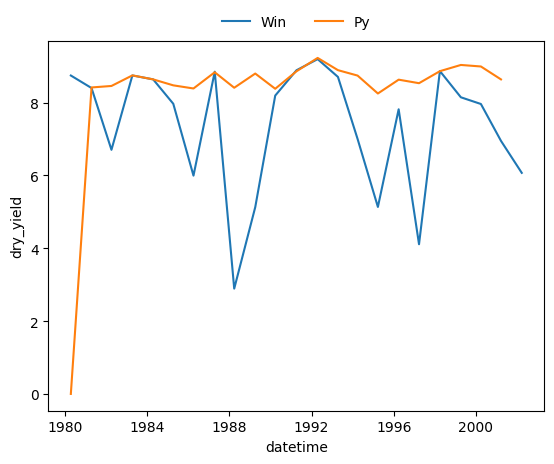

In [23]:
# Tunis climate
filepath=get_filepath('tunis_climate.txt')
tunis_weather = prepare_weather(filepath)

# Local Tunis soil
tunis_soil = Soil(soil_type='ac_TunisLocal')

# crops
wheat = Crop('WheatGDD', planting_date='10/15')

# IWC
wet_dry = InitialWaterContent(wc_type='Num',
                              method='Depth',
                              depth_layer=[0.3,0.9],
                              value=[0.3,0.15])

# irr management
irr_mngt = IrrigationManagement(irrigation_method=0)

model = AquaCropModel(sim_start_time=f'{1979}/10/15',
                      sim_end_time=f'{2002}/03/24',
                      weather_df=tunis_weather,
                      soil=tunis_soil,
                      crop=wheat,
                      irrigation_management=irr_mngt,
                      initial_water_content=wet_dry,
                      )
model.run_model(till_termination=True)

outputs=run_comparison('Tun_WW_LocalSoil', model)

### Exercise 7.1 with Sandy Loam

c:\Users\s10034cb\AppData\Local\anaconda3\envs\aquacrop-v7-improvements\lib\site-packages\aquacrop\solution\HIadj_pre_anthesis.py:51: RuntimeWarning: invalid value encountered in double_scalars
  Br = NewCond_B / NewCond_B_NS
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20588\1651980893.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20588\1651980893.py:56: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCrop

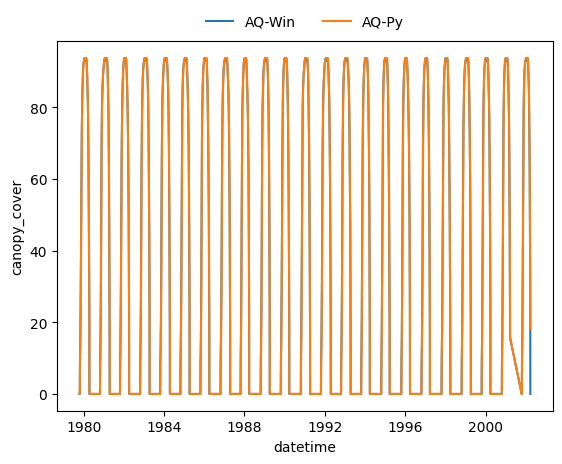

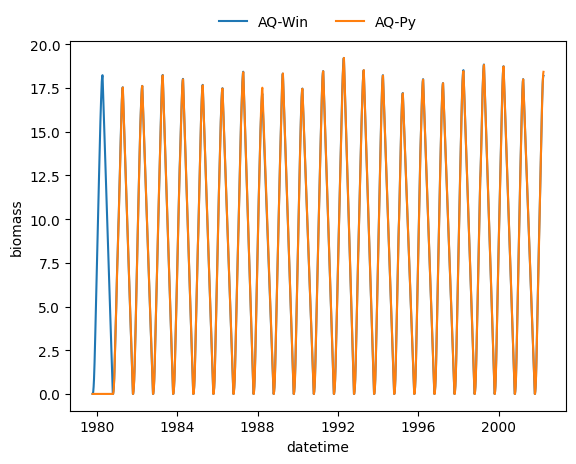

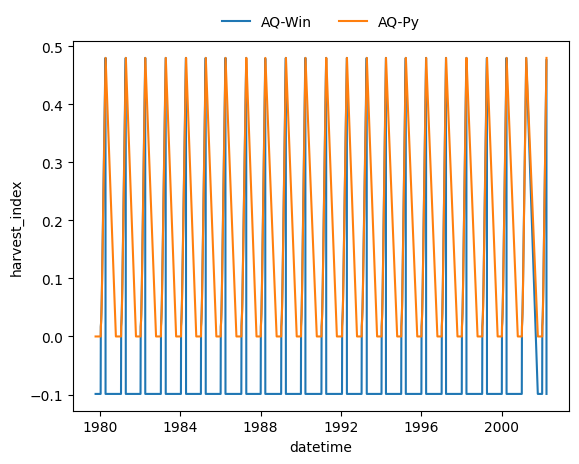

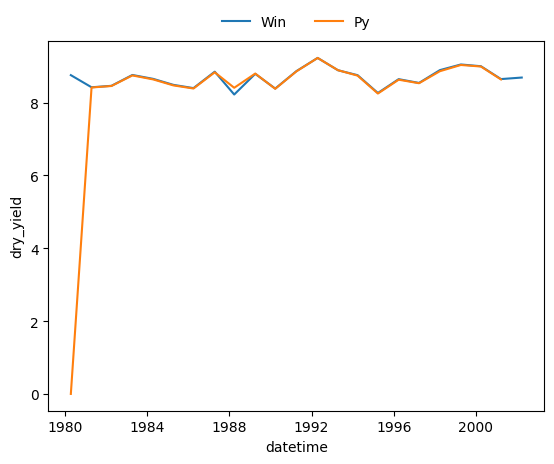

In [24]:
# Sandy loam soil
sandy_loam = Soil(soil_type='SandyLoam')

model = AquaCropModel(sim_start_time=f'{1979}/10/15',
                      sim_end_time=f'{2002}/03/24',
                      weather_df=tunis_weather,
                      soil=sandy_loam,
                      crop=wheat,
                      irrigation_management=irr_mngt,
                      initial_water_content=wet_dry,
                      )
model.run_model(till_termination=True)

run_comparison('Tun_WW_SLSoil', model)

## Exercise 7.2 Local wheat variety

c:\Users\s10034cb\AppData\Local\anaconda3\envs\aquacrop-v7-improvements\lib\site-packages\aquacrop\solution\HIadj_pre_anthesis.py:51: RuntimeWarning: invalid value encountered in double_scalars
  Br = NewCond_B / NewCond_B_NS
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20588\1651980893.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20588\1651980893.py:56: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCrop

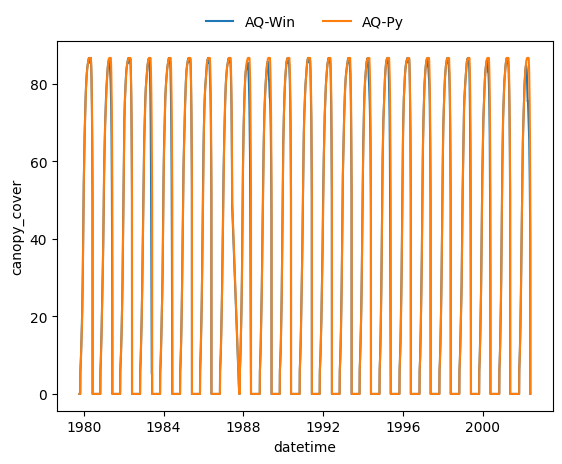

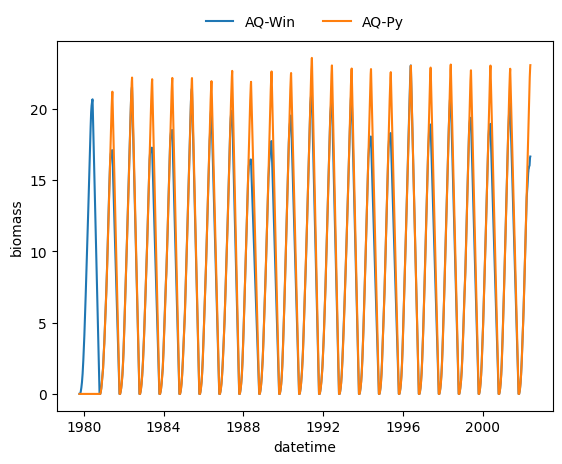

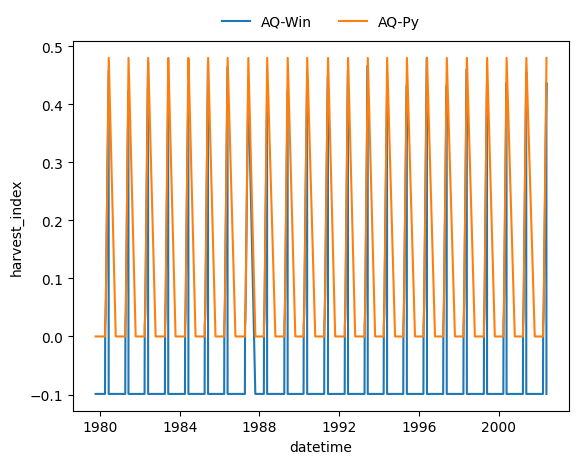

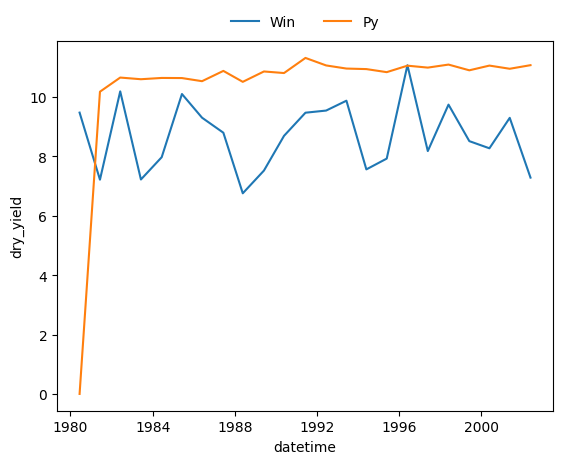

In [25]:
# Local wheat variety
local_wheat=Crop('WheatLongGDD', planting_date= '10/15')

model = AquaCropModel(sim_start_time=f'{1979}/10/15',
                      sim_end_time=f'{2002}/05/31',
                      weather_df=tunis_weather,
                      soil=sandy_loam,
                      crop=local_wheat,
                      irrigation_management=irr_mngt,
                      initial_water_content=wet_dry,
                      )
model.run_model(till_termination=True)

run_comparison('Tun_WW_LongVar2', model)

## Exercise 7.3 Different initial conditions

WetDry

c:\Users\s10034cb\AppData\Local\anaconda3\envs\aquacrop-v7-improvements\lib\site-packages\aquacrop\solution\HIadj_pre_anthesis.py:51: RuntimeWarning: invalid value encountered in double_scalars
  Br = NewCond_B / NewCond_B_NS
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20588\1651980893.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20588\1651980893.py:56: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCrop

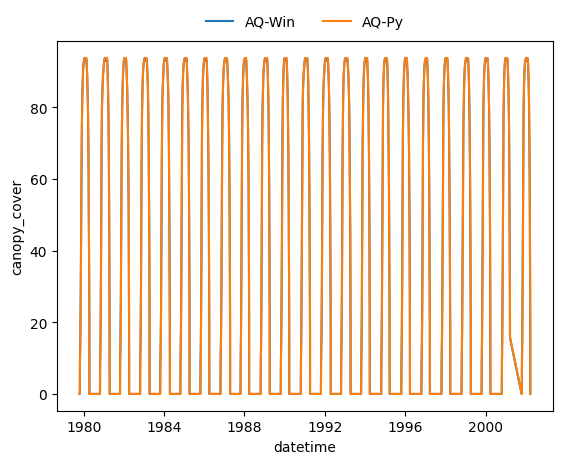

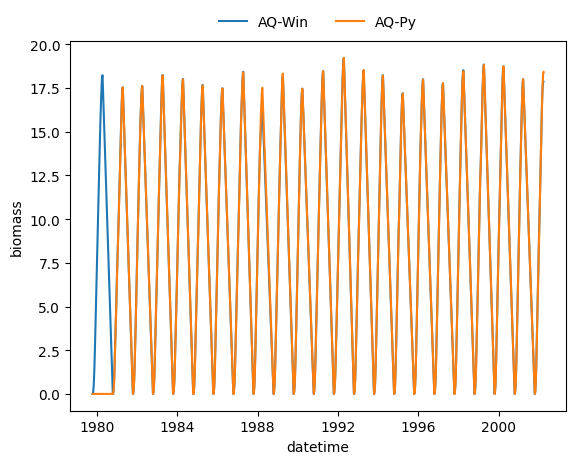

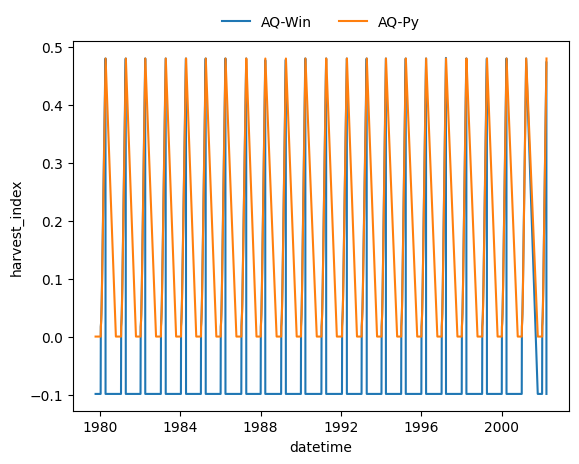

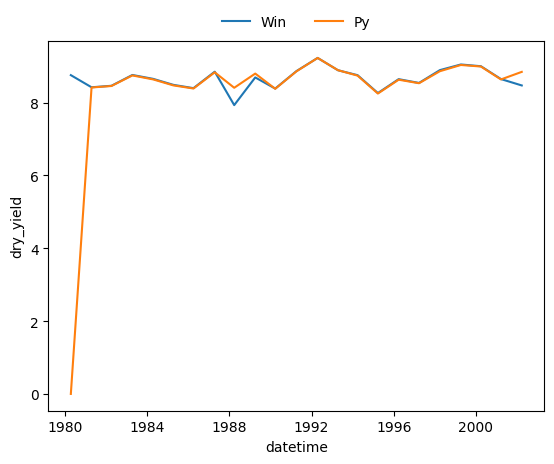

In [26]:
model = AquaCropModel(sim_start_time=f'{1979}/10/15',
                      sim_end_time=f'{2002}/05/31',
                      weather_df=tunis_weather,
                      soil=sandy_loam,
                      crop=wheat,
                      irrigation_management=irr_mngt,
                      initial_water_content=wet_dry,
                      )
model.run_model(till_termination=True)
run_comparison('Tun_WW_WetDry', model)

Field Capacity:

c:\Users\s10034cb\AppData\Local\anaconda3\envs\aquacrop-v7-improvements\lib\site-packages\aquacrop\solution\HIadj_pre_anthesis.py:51: RuntimeWarning: invalid value encountered in double_scalars
  Br = NewCond_B / NewCond_B_NS
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20588\1651980893.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20588\1651980893.py:56: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCrop

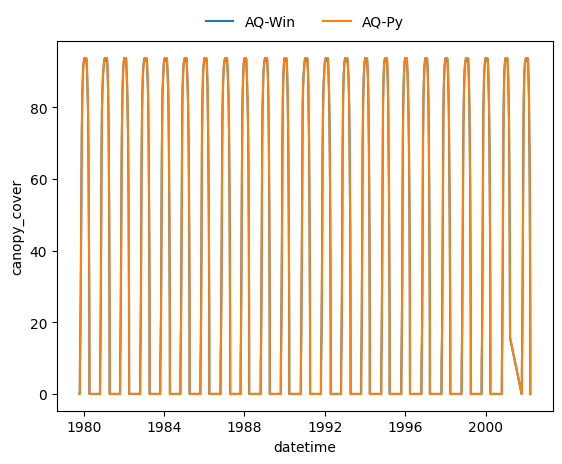

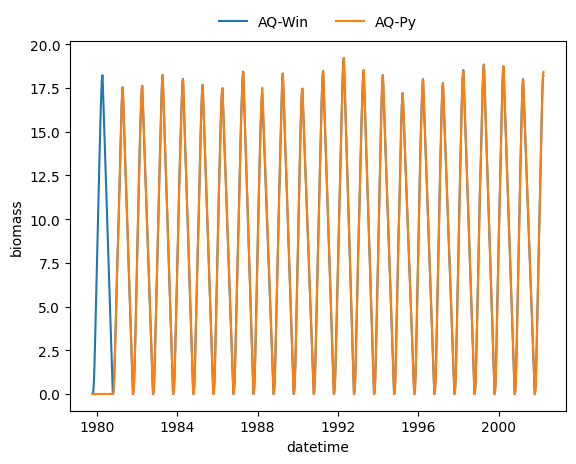

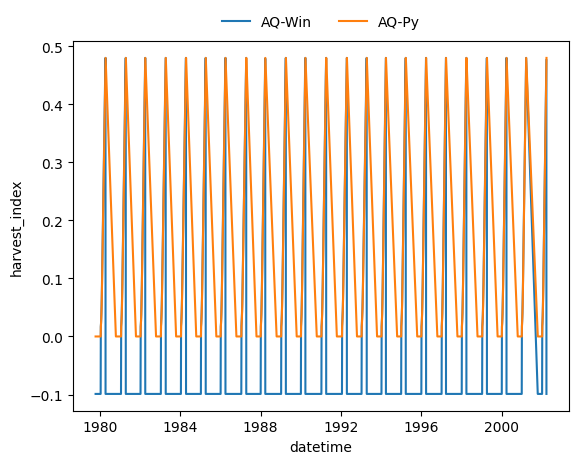

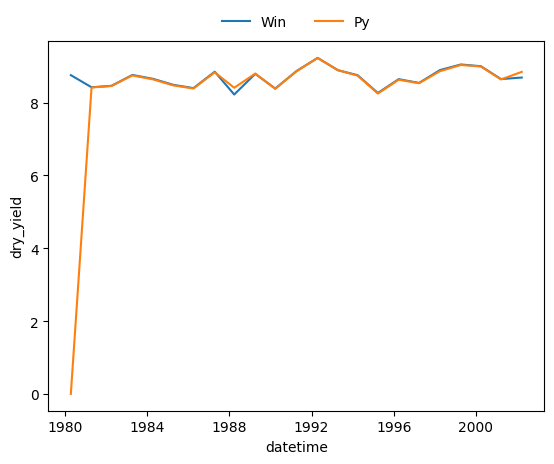

In [27]:
# Change initial water content 
field_capacity = InitialWaterContent(value=['FC'])

model = AquaCropModel(sim_start_time=f'{1979}/10/15',
                      sim_end_time=f'{2002}/05/31',
                      weather_df=tunis_weather,
                      soil=sandy_loam,
                      crop=wheat,
                      irrigation_management=irr_mngt,
                      initial_water_content=field_capacity,
                      )
model.run_model(till_termination=True)
run_comparison('Tun_WW_FC', model)

30% TAW

c:\Users\s10034cb\AppData\Local\anaconda3\envs\aquacrop-v7-improvements\lib\site-packages\aquacrop\solution\HIadj_pre_anthesis.py:51: RuntimeWarning: invalid value encountered in double_scalars
  Br = NewCond_B / NewCond_B_NS
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20588\1651980893.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20588\1651980893.py:56: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCrop

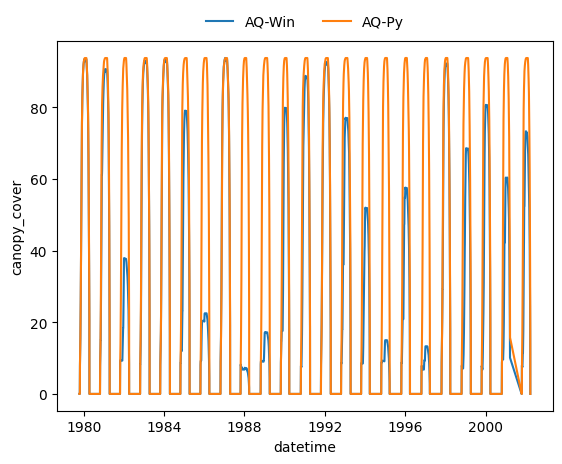

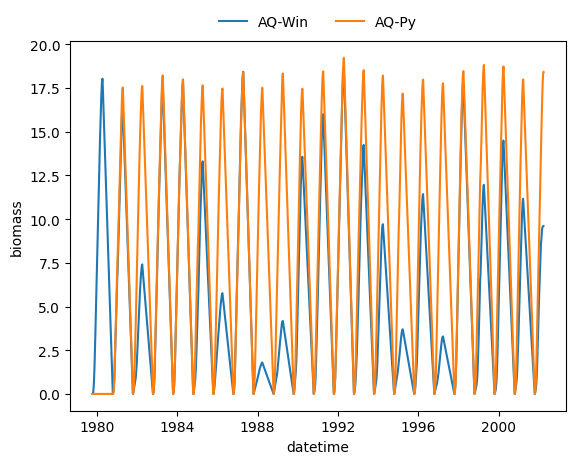

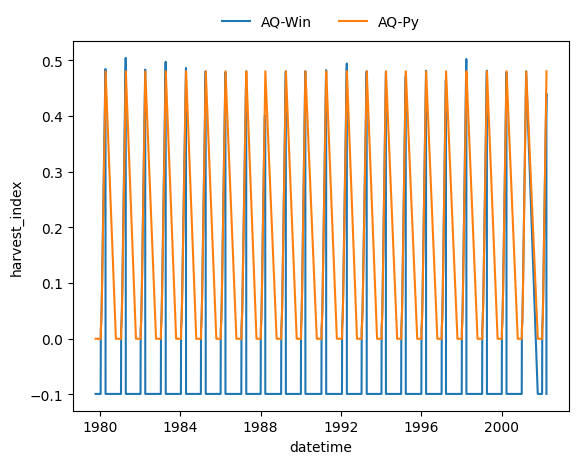

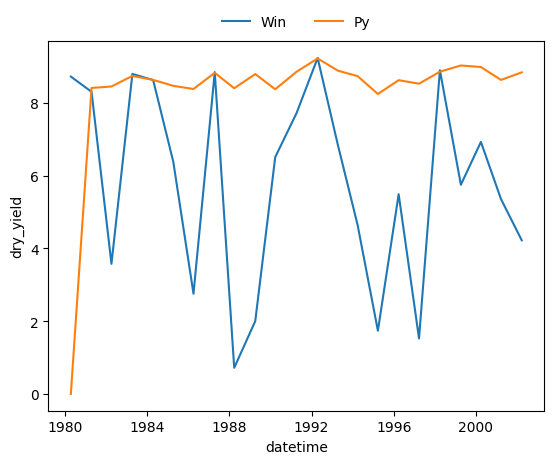

In [28]:
# Change initial water content
iwc30taw = InitialWaterContent('Pct','Layer',[1],[30])

model = AquaCropModel(sim_start_time=f'{1979}/10/15',
                      sim_end_time=f'{2002}/05/31',
                      weather_df=tunis_weather,
                      soil=sandy_loam,
                      crop=wheat,
                      irrigation_management=irr_mngt,
                      initial_water_content=iwc30taw,
                      )
model.run_model(till_termination=True)
run_comparison('Tun_WW_30TAW', model)

75% TAW

c:\Users\s10034cb\AppData\Local\anaconda3\envs\aquacrop-v7-improvements\lib\site-packages\aquacrop\solution\HIadj_pre_anthesis.py:51: RuntimeWarning: invalid value encountered in double_scalars
  Br = NewCond_B / NewCond_B_NS
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20588\1651980893.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20588\1651980893.py:56: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCrop

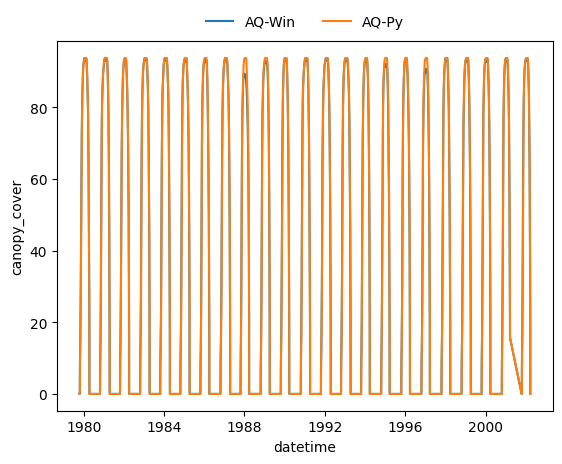

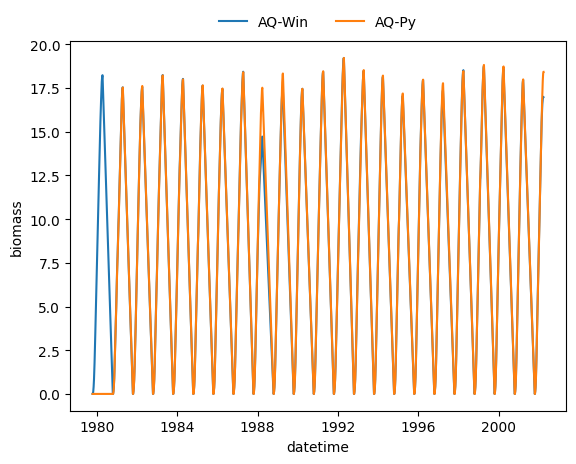

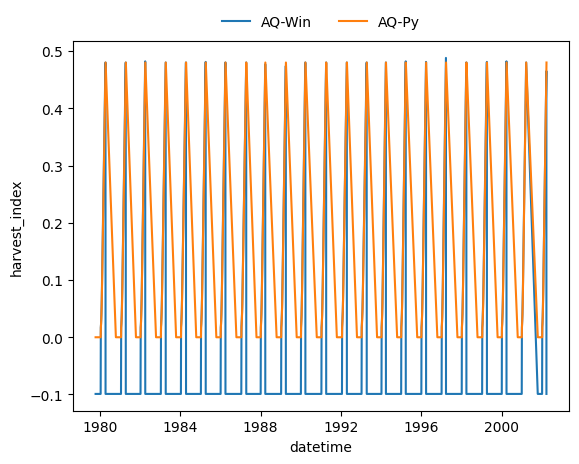

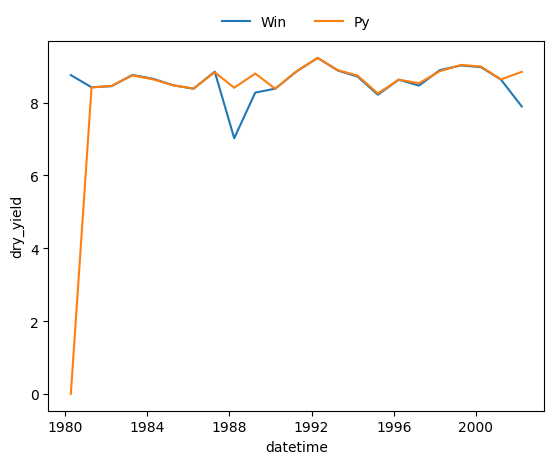

In [29]:
# Change initial water content
iwc75taw = InitialWaterContent('Pct','Layer',[1],[75])

model = AquaCropModel(sim_start_time=f'{1979}/10/15',
                      sim_end_time=f'{2002}/05/31',
                      weather_df=tunis_weather,
                      soil=sandy_loam,
                      crop=wheat,
                      irrigation_management=irr_mngt,
                      initial_water_content=iwc75taw,
                      )
model.run_model(till_termination=True)
run_comparison('Tun_WW_75TAW', model)

## Exercise 7.6 Net irrigation requirement

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20588\1651980893.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20588\1651980893.py:56: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


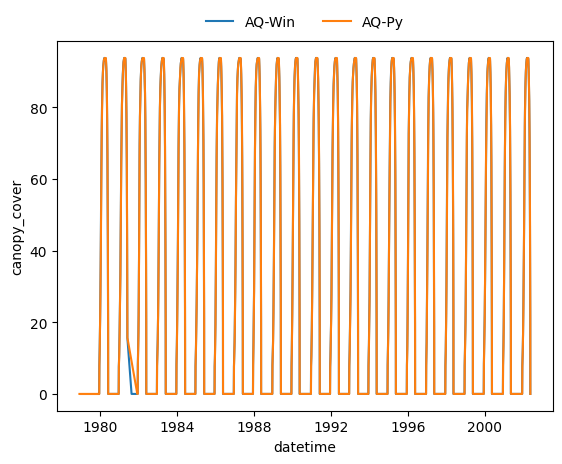

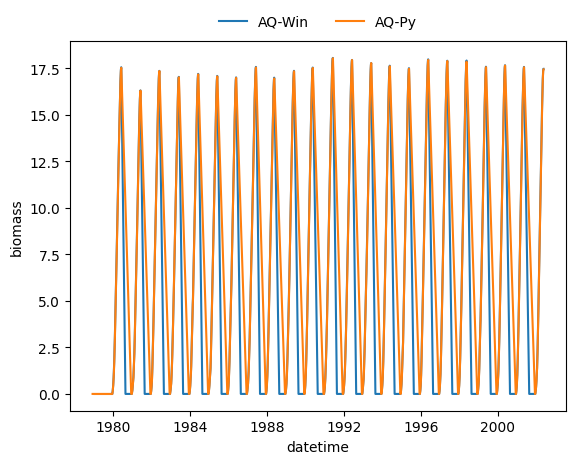

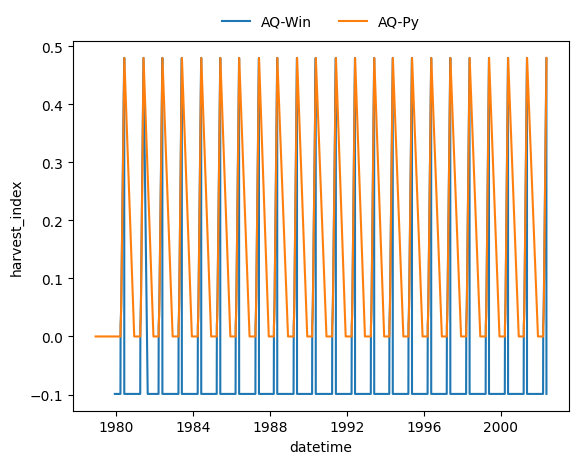

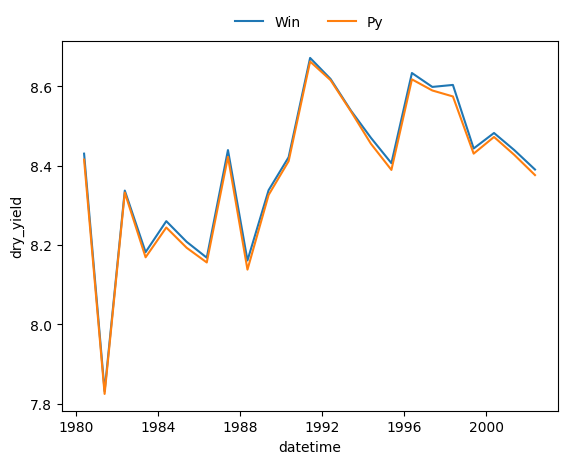

In [30]:
net_irr = IrrigationManagement(irrigation_method=4,net_irr=78.26)
wp = InitialWaterContent(value=['WP'])
wheat_dec = Crop('WheatGDD',planting_date='12/01',harvest_date='07/30')

model = AquaCropModel(sim_start_time=f'{1979}/08/15',
                      sim_end_time=f'{2002}/05/31',
                      weather_df=tunis_weather,
                      soil=sandy_loam,
                      crop=wheat_dec,
                      irrigation_management=net_irr,
                      initial_water_content=wp,
                      )
model.run_model(till_termination=True)

run_comparison('Tun_WW_NetIrr', model)

## Exercise 7.7 Assess deficit irrigation schedules

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20588\1651980893.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20588\1651980893.py:56: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


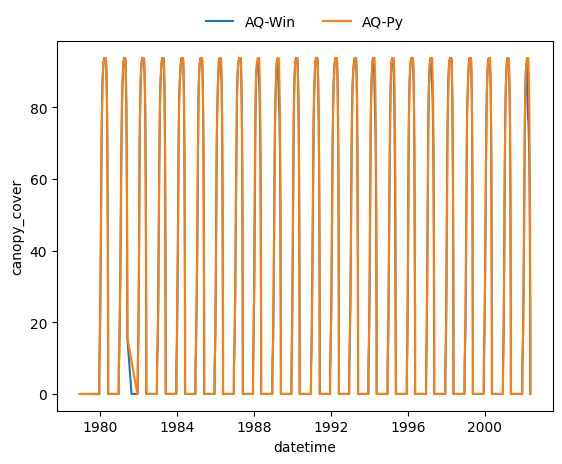

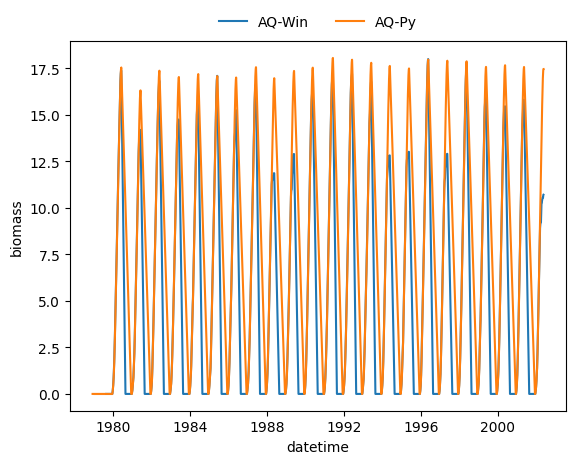

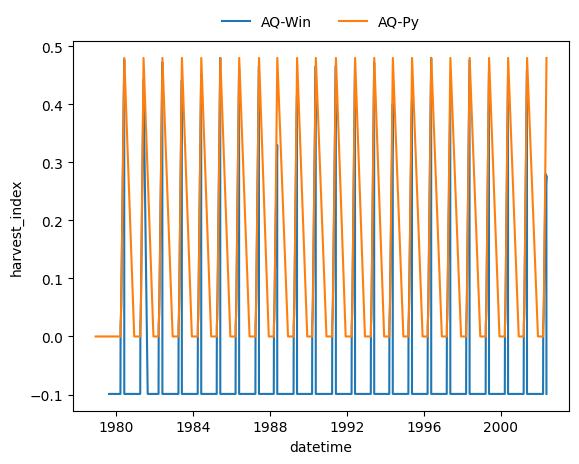

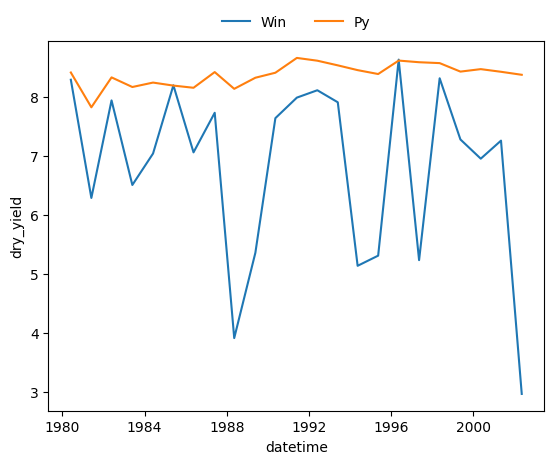

In [31]:
all_days=pd.date_range('1979/12/01', '2001/12/01',freq='12MS')

dates=[]

for each_start in all_days:
    app1=each_start
    app2=each_start+pd.Timedelta(30,'d')
    app3=each_start+pd.Timedelta(60,'d')
    dates.extend([app1,app2,app3])

n_years=len(all_days)
depths=[30,40,40]*n_years

schedule=pd.DataFrame([dates,depths]).T # create pandas DataFrame
schedule.columns=['Date','Depth'] # name columns

net_irr = IrrigationManagement(irrigation_method=3, Schedule=schedule)
wp = InitialWaterContent(wc_type='Pct',method='Layer',depth_layer=[1],value=[10])
wheat_dec = Crop('WheatGDD',planting_date='12/01')

model = AquaCropModel(sim_start_time=f'{1979}/08/15',
                      sim_end_time=f'{2002}/05/31',
                      weather_df=tunis_weather,
                      soil=sandy_loam,
                      crop=wheat_dec,
                      irrigation_management=net_irr,
                      initial_water_content=wp,
                      )
model.run_model(till_termination=True)

run_comparison('Tun_WW_Deficit2', model)

# Exercise 8

## Exercise 8.2 Paddy rice in Hyderabad planting dates

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20588\1651980893.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20588\1651980893.py:56: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


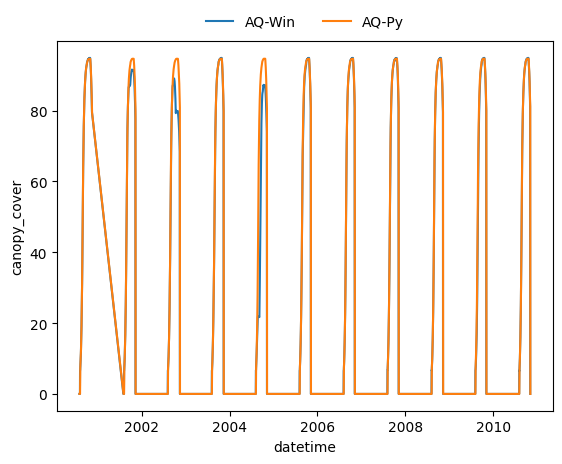

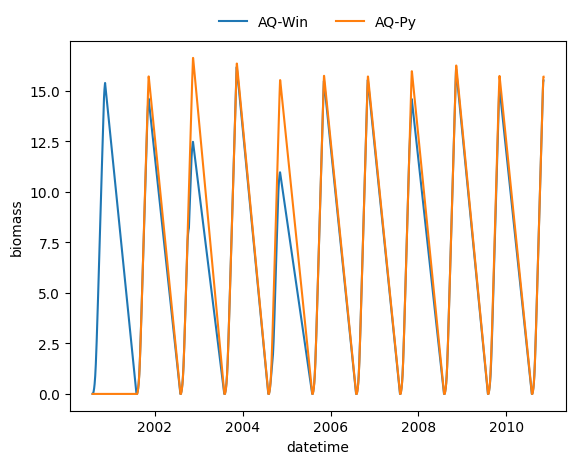

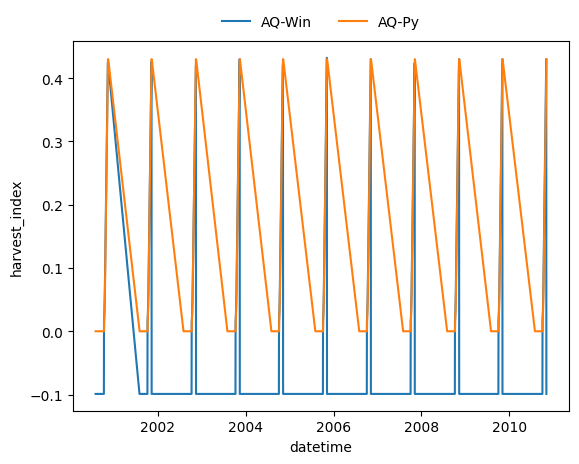

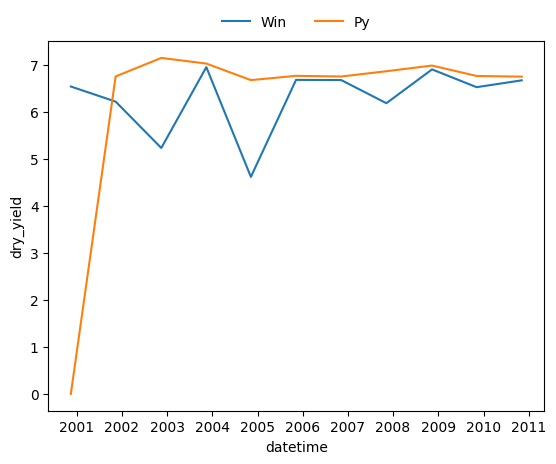

In [32]:
# Hyderabad climate
filepath=get_filepath('hyderabad_climate.txt')
hyderabad_weather = prepare_weather(filepath)

# Hyderabad soil
paddy_soil = Soil(soil_type='Paddy')

# crop
local_rice = Crop('localpaddy', planting_date='08/01')

# IWC
fc = InitialWaterContent(value=['FC'])

# irr management
irr_mngt = IrrigationManagement(irrigation_method=0)

# field management
bunds20 = FieldMngt(bunds=True, z_bund=0.20)

model = AquaCropModel(sim_start_time=f'{2000}/08/01',
                      sim_end_time=f'{2010}/12/31',
                      weather_df=hyderabad_weather,
                      soil=paddy_soil,
                      crop=local_rice,
                      field_management=bunds20,
                      irrigation_management=irr_mngt,
                      initial_water_content=fc,
                      )
model.run_model(till_termination=True)

run_comparison('Hyd_Rice_1Aug_check', model)

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20588\1651980893.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20588\1651980893.py:56: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


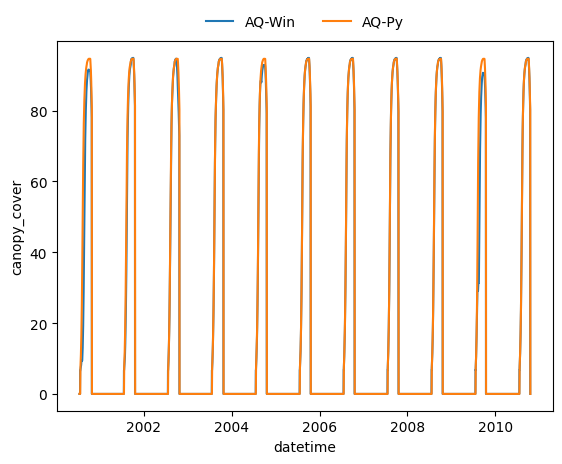

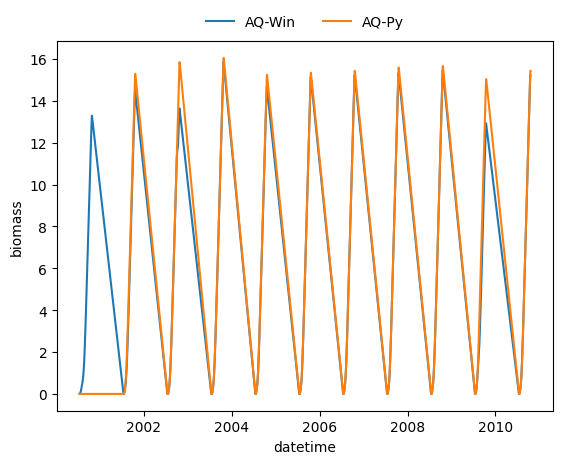

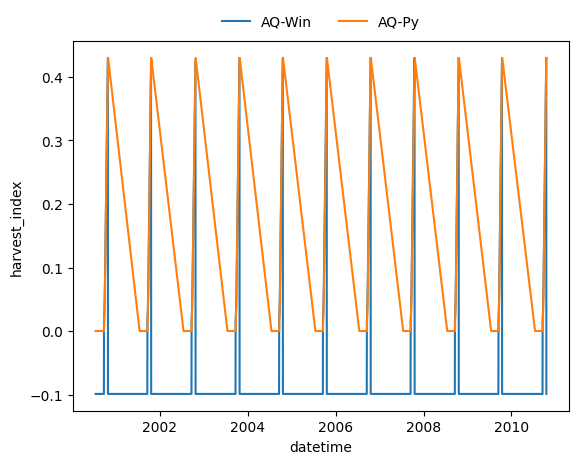

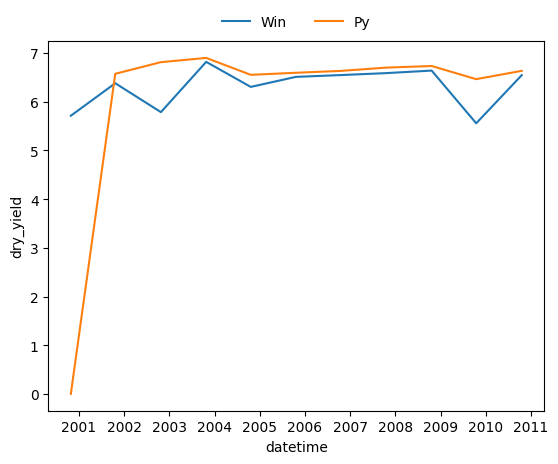

In [33]:
# crop
local_rice = Crop('localpaddy', planting_date='07/15')

model = AquaCropModel(sim_start_time=f'{2000}/07/15',
                      sim_end_time=f'{2010}/12/31',
                      weather_df=hyderabad_weather,
                      soil=paddy_soil,
                      crop=local_rice,
                      field_management=bunds20,
                      irrigation_management=irr_mngt,
                      initial_water_content=fc,
                      )
model.run_model(till_termination=True)

run_comparison('Hyd_Rice_15Jul_check', model)

## Exercise 8.3 Initial conditions

Field capacity

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20588\1651980893.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20588\1651980893.py:56: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


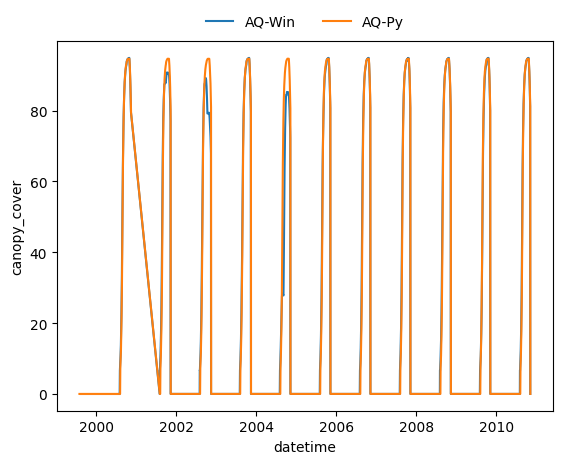

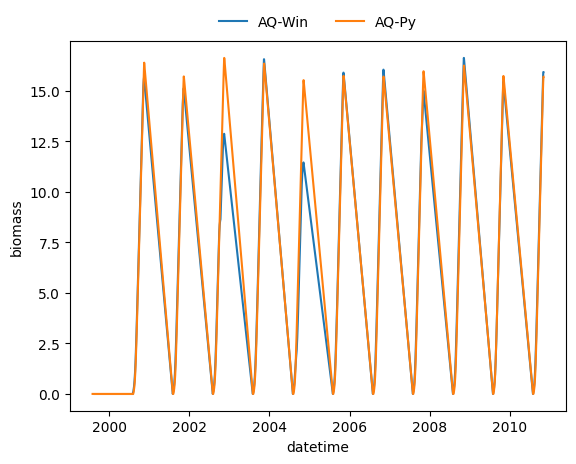

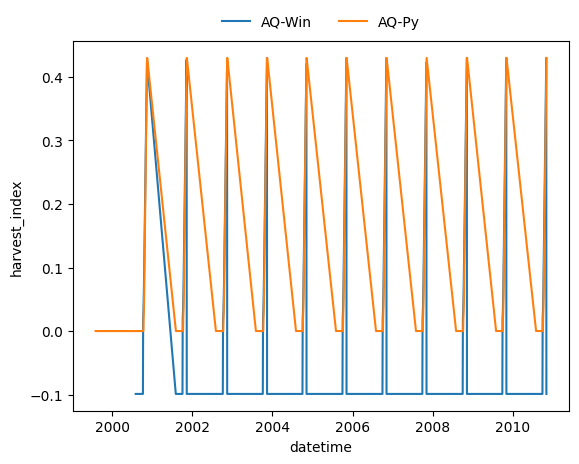

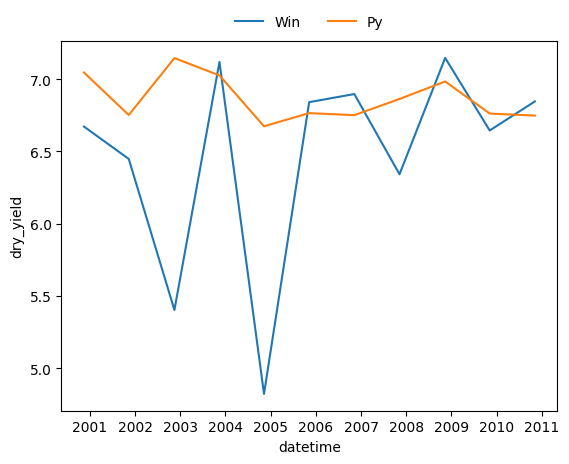

In [34]:
# Hyderabad climate
filepath=get_filepath('hyderabad_climate.txt')
hyderabad_weather = prepare_weather(filepath)

# Local Brussels soil
paddy_soil = Soil(soil_type='Paddy')

# crop
local_rice = Crop('localpaddy', planting_date='08/01')

# IWC
fc = InitialWaterContent(value=['FC'])

# irr management
irr_mngt = IrrigationManagement(irrigation_method=0)

model = AquaCropModel(sim_start_time=f'{2000}/01/01',
                      sim_end_time=f'{2010}/12/31',
                      weather_df=hyderabad_weather,
                      soil=paddy_soil,
                      crop=local_rice,
                      irrigation_management=irr_mngt,
                      field_management=bunds20,
                      initial_water_content=fc,
                      )
model.run_model(till_termination=True)

run_comparison('Hyd_Rice_FC', model)

30% TAW

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20588\1651980893.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20588\1651980893.py:56: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


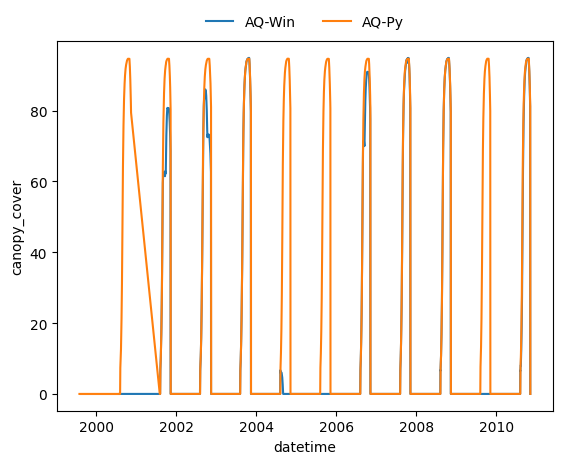

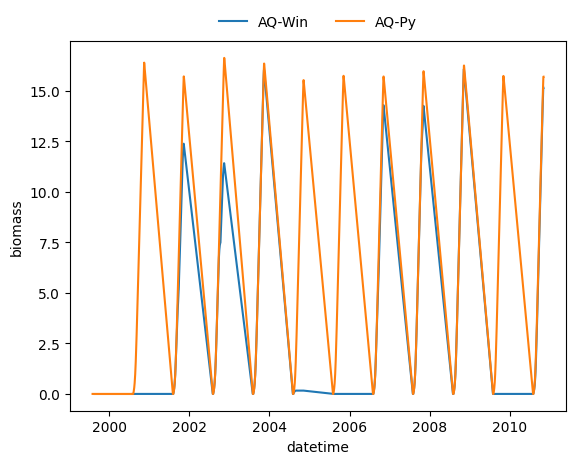

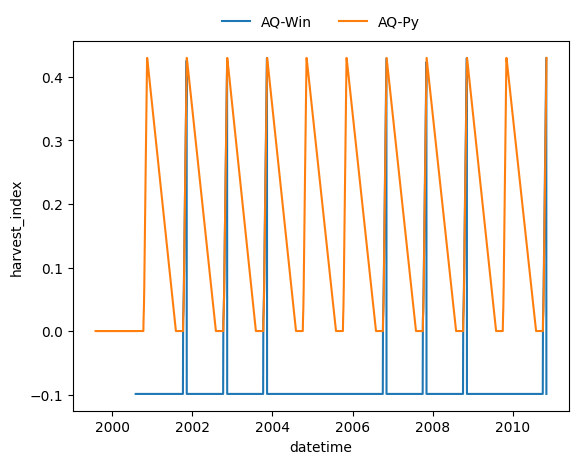

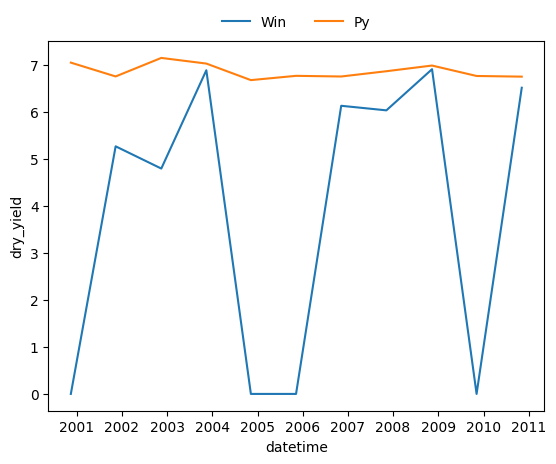

In [35]:
# IWC
taw30 = InitialWaterContent('Pct','Layer',[1],[30])
model = AquaCropModel(sim_start_time=f'{2000}/01/01',
                      sim_end_time=f'{2010}/12/31',
                      weather_df=hyderabad_weather,
                      soil=paddy_soil,
                      crop=local_rice,
                      irrigation_management=irr_mngt,
                      field_management=bunds20,
                      initial_water_content=taw30,
                      )
model.run_model(till_termination=True)

run_comparison('Hyd_Rice_30TAW', model)

75% TAW

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20588\1651980893.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20588\1651980893.py:56: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


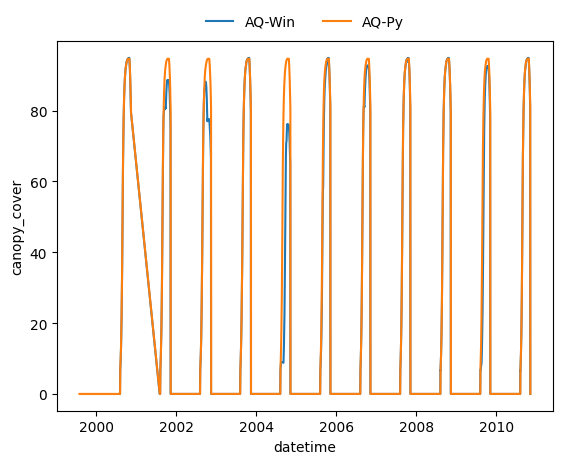

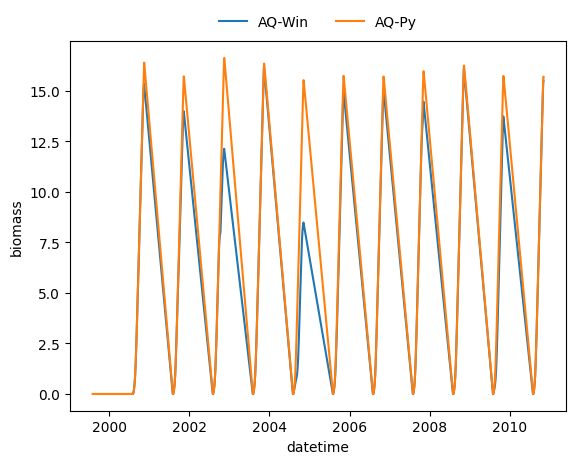

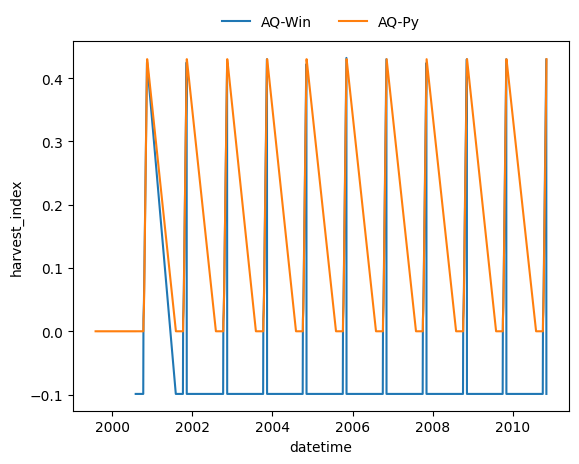

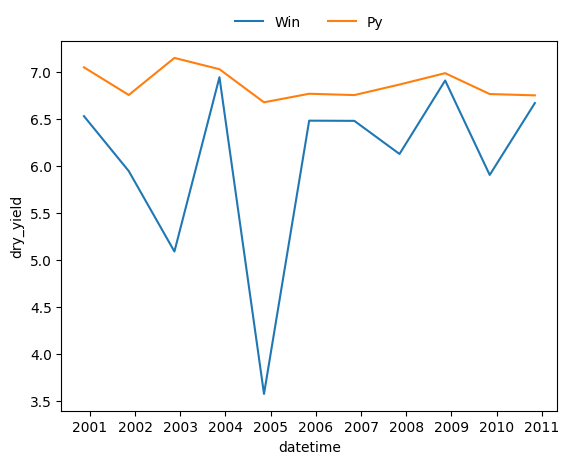

In [36]:
# IWC
taw75 = InitialWaterContent('Pct','Layer',[1,2],[75,75])

model = AquaCropModel(sim_start_time=f'{2000}/01/01',
                      sim_end_time=f'{2010}/12/31',
                      weather_df=hyderabad_weather,
                      soil=paddy_soil,
                      crop=local_rice,
                      field_management=bunds20,
                      irrigation_management=irr_mngt,
                      initial_water_content=taw75,
                      )
model.run_model(till_termination=True)

run_comparison('Hyd_Rice_75TAW', model)

Wet Top

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20588\1651980893.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_20588\1651980893.py:56: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


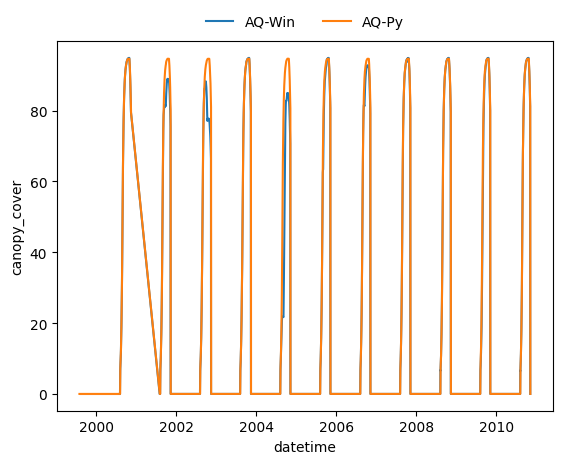

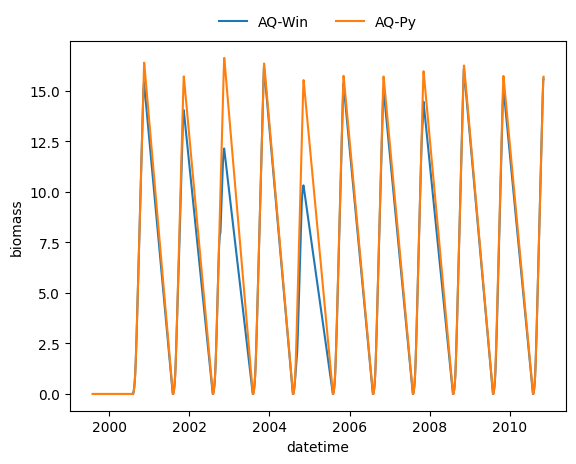

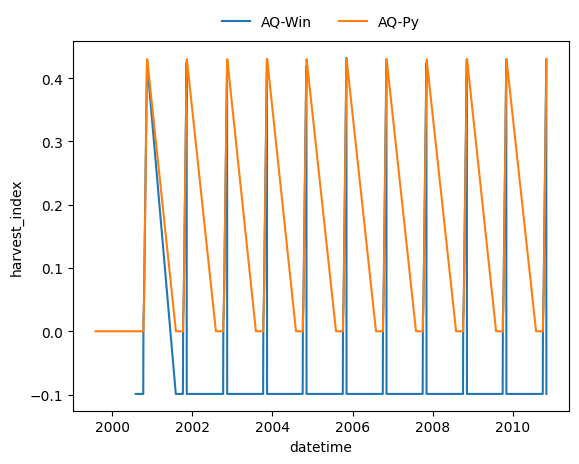

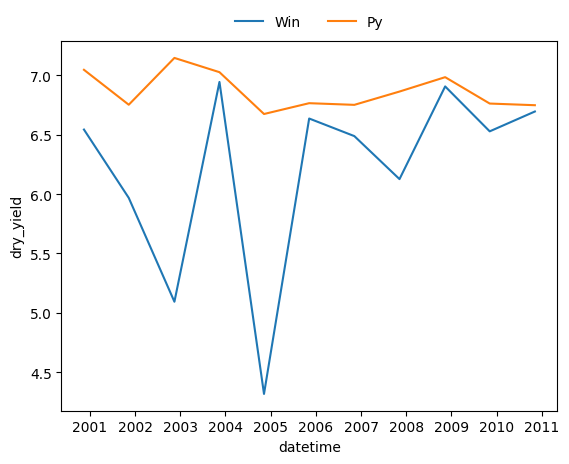

In [37]:
# IWC
wetTop = InitialWaterContent('Prop','Depth',[0.5,2],['FC','WP'])

model = AquaCropModel(sim_start_time=f'{2000}/01/01',
                      sim_end_time=f'{2010}/12/31',
                      weather_df=hyderabad_weather,
                      soil=paddy_soil,
                      crop=local_rice,
                      field_management=bunds20,
                      irrigation_management=irr_mngt,
                      initial_water_content=wetTop,
                      )
model.run_model(till_termination=True)

run_comparison('Hyd_Rice_wetTop', model)

# Exercise 9

## Exercise 9.1 Potato in Brussels

In [38]:
# Brussels climate
filepath=get_filepath('brussels_climate.txt')
brussels_weather = prepare_weather(filepath)

# Local Brussels soil
loam_soil = Soil(soil_type='Loam')

# crops
potato = Crop('PotatoLocalGDD', planting_date='04/25')

# IWC
fc = InitialWaterContent(value=['FC'])

# irr management
irr_mngt = IrrigationManagement(irrigation_method=0)

model = AquaCropModel(sim_start_time=f'{1976}/04/25', # 1976
                      sim_end_time=f'{2005}/12/31', # 2005
                      weather_df=brussels_weather,
                      soil=loam_soil,
                      crop=potato,
                      irrigation_management=irr_mngt,
                      initial_water_content=fc,
                      )
model.run_model(till_termination=True)

#daily_outputs = run_comparison_v7('Bru_Pot', model)

AssertionError: Crop name not defined in crop_params dictionary,         if defining a custom crop please use crop name 'custom'. Otherwise use one of the         pre-defined crops: dict_keys(['Barley', 'BarleyGDD', 'Cotton', 'CottonGDD', 'DryBean', 'DryBeanGDD', 'Maize', 'MaizeGDD', 'PaddyRice', 'PaddyRiceGDD', 'Potato', 'PotatoGDD', 'PotatoLocal', 'Quinoa', 'Sorghum', 'SorghumGDD', 'Soybean', 'SoybeanGDD', 'SugarBeet', 'SugarBeetGDD', 'SugarCane', 'Sunflower', 'SunflowerGDD', 'Tomato', 'TomatoGDD', 'Wheat', 'WheatGDD', 'WheatLongGDD', 'localpaddy', 'MaizeChampionGDD', 'Tef', 'AlfalfaGDD', 'Cassava'])

Get soil profile data from windows outputs

In [ ]:
win_daily_outputs = extract_win_data('Bru_Pot2')

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_14700\896082959.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  temp=pd.read_csv(path,delim_whitespace=True,encoding="ISO-8859-1", skiprows=4, skipfooter=33)
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_14700\896082959.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  temp=pd.read_csv(path,delim_whitespace=True,encoding="ISO-8859-1", skiprows=4, skipfooter=27)
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_14700\896082959.py:15: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  temp=pd.read_csv(path,delim_whitespace=True,encoding="ISO-8859-1", skiprows=4, skipfooter=19, index_col=False)
C:

In [ ]:
py_data=extract_py_data(py_model=model)

print(py_data.columns)

Index(['gdd', 'gdd_cum', 'z_root', 'canopy_cover', 'canopy_cover_ns',
       'biomass', 'biomass_ns', 'harvest_index', 'harvest_index_adj',
       'dry_yield', 'datetime', 'Wr', 'z_gw', 'surface_storage', 'IrrDay',
       'Infl', 'Runoff', 'DeepPerc', 'CR', 'GwIn', 'Es', 'EsPot', 'Tr',
       'TrPot', 'source'],
      dtype='object')


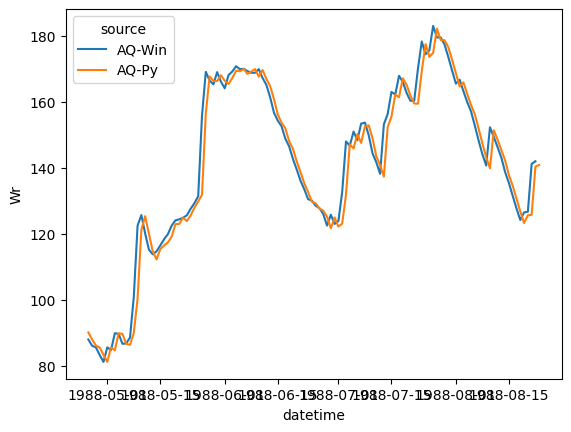

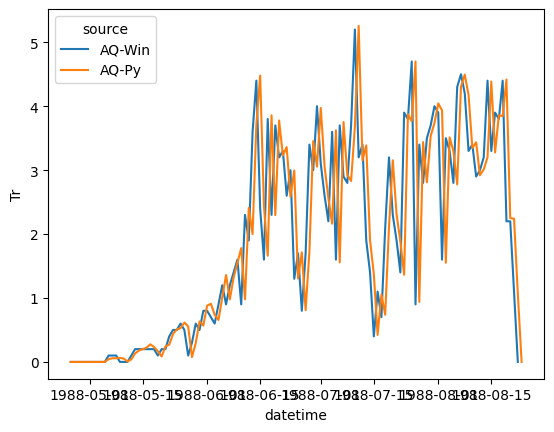

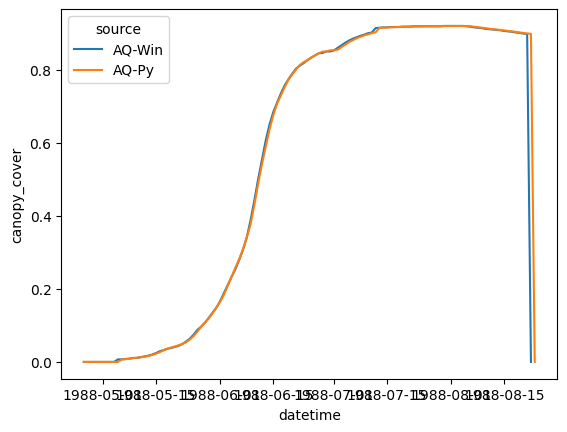

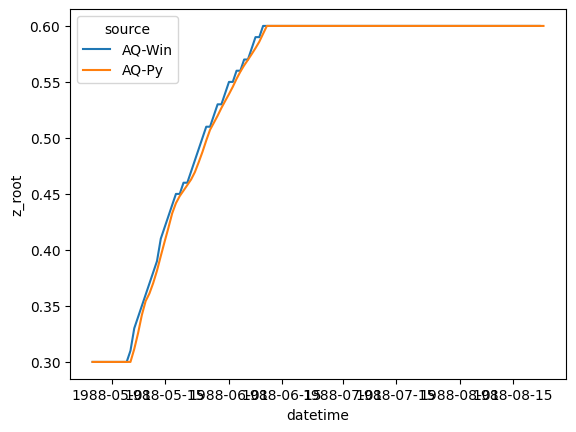

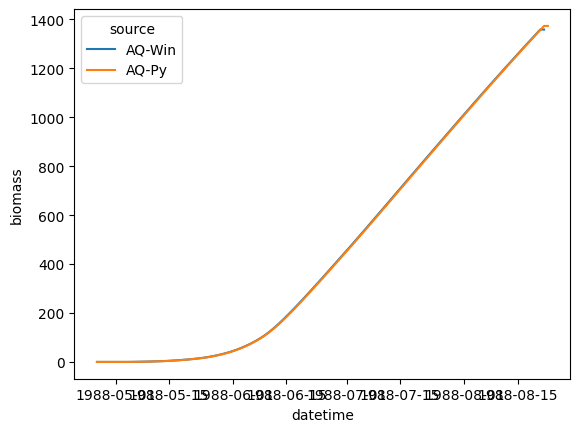

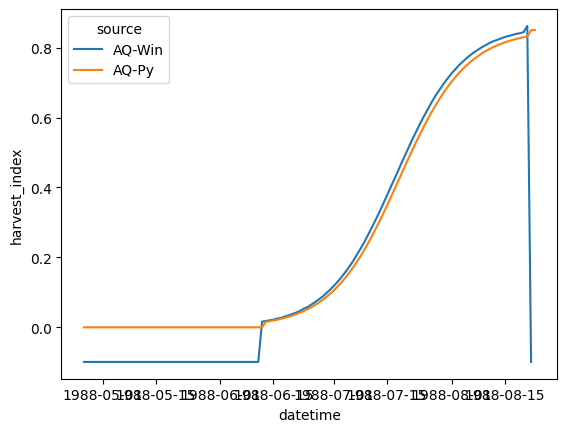

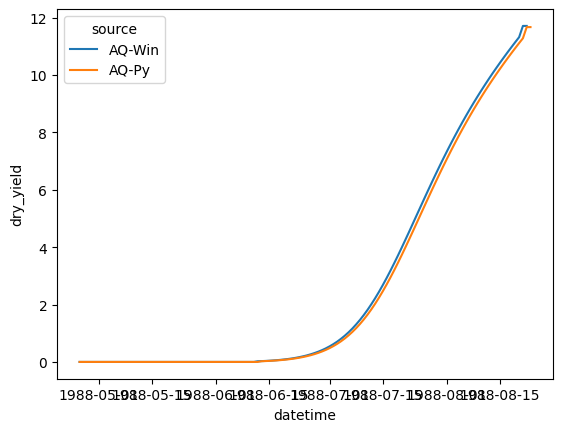

In [ ]:
# py_growth=daily_outputs[0]
# py_wflux=daily_outputs[1]
# py_wstorage=daily_outputs[2]
# #win_outputs=daily_outputs[0]

# print(py_growth.columns)
# print(py_wflux.columns)
# print(py_wstorage.columns)

win_outputs_88=win_daily_outputs[(win_daily_outputs['datetime'] > '1988-04-25') & (win_daily_outputs['datetime'] < '1988-12-31')]
py_outputs_88=py_data[(py_data['datetime'] > '1988-04-25') & (py_data['datetime'] < '1988-12-31')]
# start_year,start_month,start_day='1987','04','25'
# py_wflux['datetime']=py_wflux.apply(lambda x:datetime.datetime(int(x['season_counter']+int(start_year)),int(start_month),int(start_day)+1)+datetime.timedelta(int(x['dap']-1)),axis=1)
# py_wflux['source']='AQ-Py'




combined_87_88=pd.concat([win_outputs_88, py_outputs_88])

g1=sns.lineplot(data=combined_87_88, x='datetime',y='Wr', hue='source')
#sns.move_legend(g1, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
plt.show()

g1=sns.lineplot(data=combined_87_88, x='datetime',y='Tr', hue='source')
#sns.move_legend(g1, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
plt.show()

g1=sns.lineplot(data=combined_87_88, x='datetime',y='canopy_cover', hue='source')
#sns.move_legend(g1, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
plt.show()

g1=sns.lineplot(data=combined_87_88, x='datetime',y='z_root', hue='source')
#sns.move_legend(g1, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
plt.show()

g1=sns.lineplot(data=combined_87_88, x='datetime',y='biomass', hue='source')
#sns.move_legend(g1, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
plt.show()

g1=sns.lineplot(data=combined_87_88, x='datetime',y='harvest_index', hue='source')
#sns.move_legend(g1, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
plt.show()

g1=sns.lineplot(data=combined_87_88, x='datetime',y='dry_yield', hue='source')
#sns.move_legend(g1, 'lower center', bbox_to_anchor=(.5,1), ncol=2, title=None, frameon=False)
plt.show()


In [ ]:
combined_87_88.to_csv('combined-outputs.csv', index = False, encoding='utf-8')

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_14700\3016353305.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_14700\3016353305.py:56: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


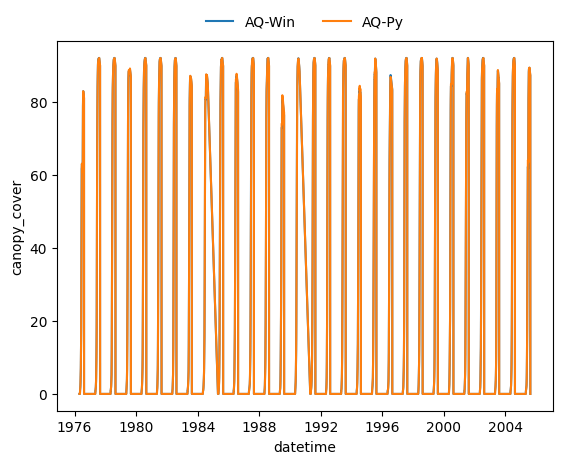

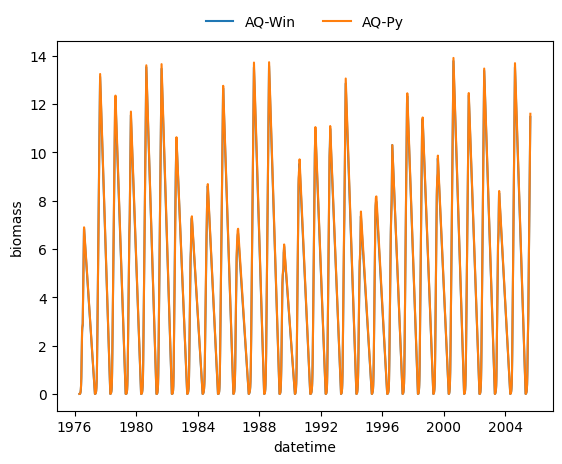

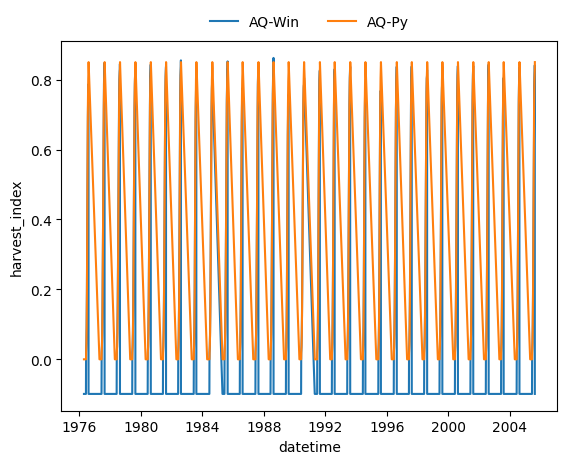

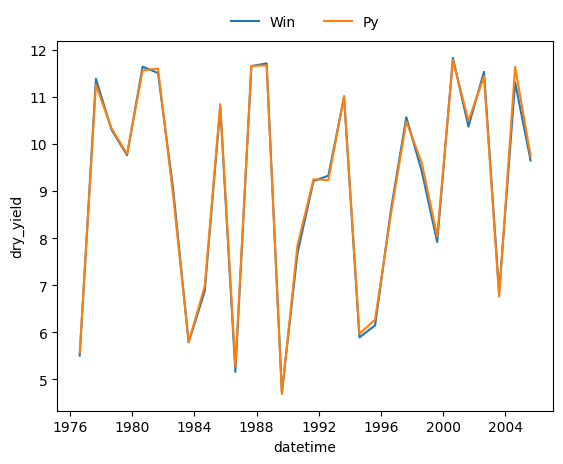

In [ ]:
run_comparison('Bru_Pot2',model)

## 9.4 Net irrigation requirement

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_14700\3016353305.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_14700\3016353305.py:56: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


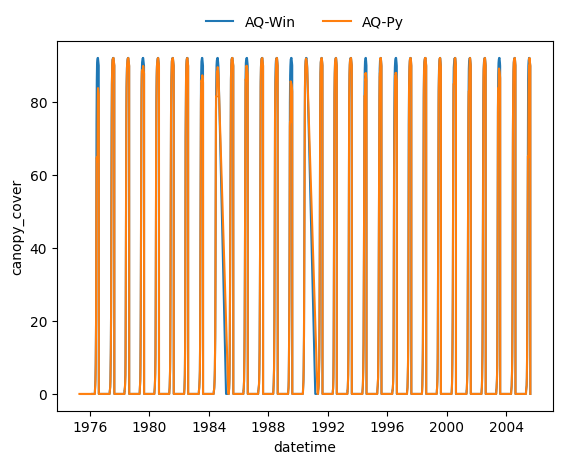

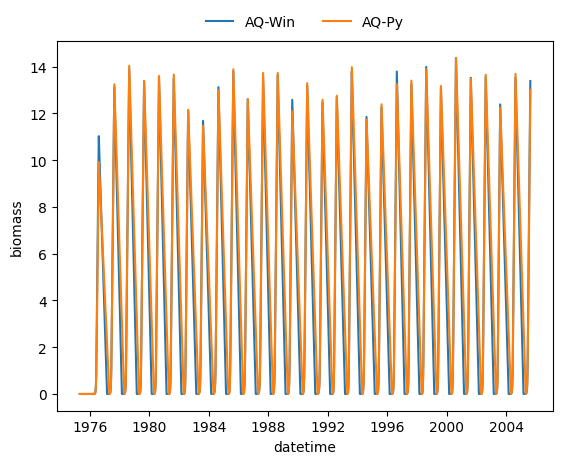

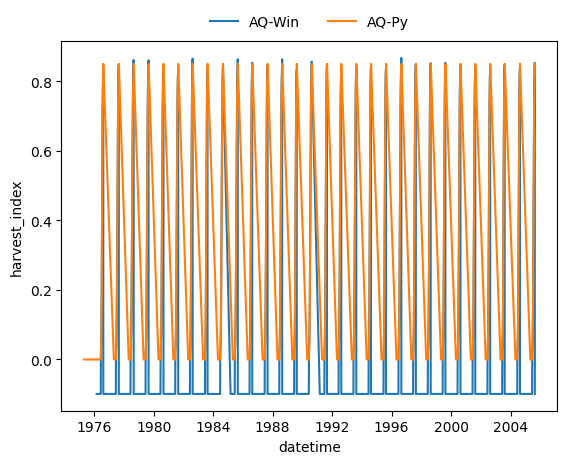

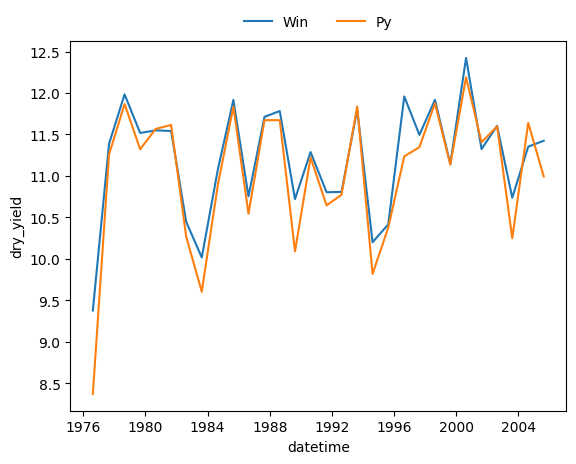

In [ ]:
# Exercise states 35% of RAW, that's what I have input into the irrigation file in AQ-Win
# AQ-Py only deals with TAW, not RAW, so a conversion must be done.
# Conversion is based on the p_up2 attribute of crop, reflects proportion of TAW that is RAW.
# In this case (PotatoLocalGDD) has p_up2 of 0.6 so 35 * 0.6 = 21

net_irr = IrrigationManagement(irrigation_method=4,NetIrrSMT=21)

model = AquaCropModel(sim_start_time=f'{1976}/03/01',
                      sim_end_time=f'{2005}/12/31',
                      weather_df=brussels_weather,
                      soil=loam_soil,
                      crop=potato,
                      irrigation_management=net_irr,
                      initial_water_content=fc,
                      )
model.run_model(till_termination=True)

run_comparison('Bru_Pot_NetIrr2', model)

## 9.5 Generating irrigation schedules

In [ ]:
# function to return the irrigation depth to apply on next day
def get_depth(model, taw):    
    t = model._clock_struct.time_step_counter # current timestep
    if t>0 and model._init_cond.depletion/model._init_cond.taw > taw:
        depth=15
    else:
        depth=0

    return depth

36% RAW allowable depletion

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_14700\3016353305.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_14700\3016353305.py:56: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


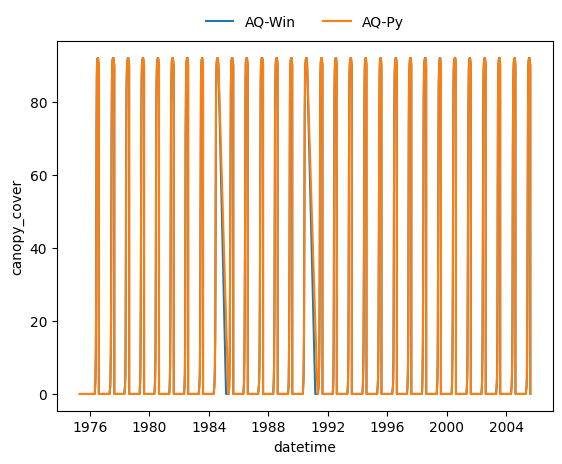

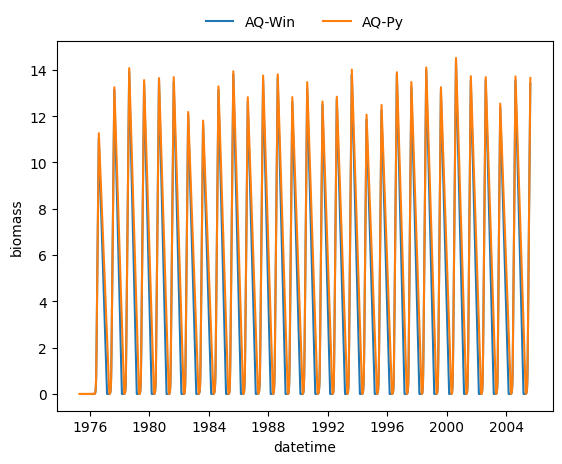

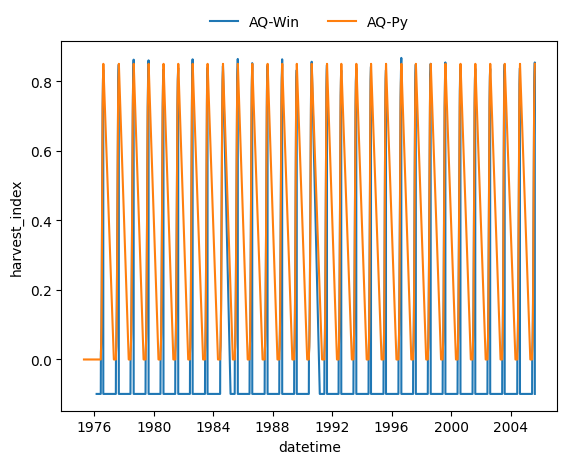

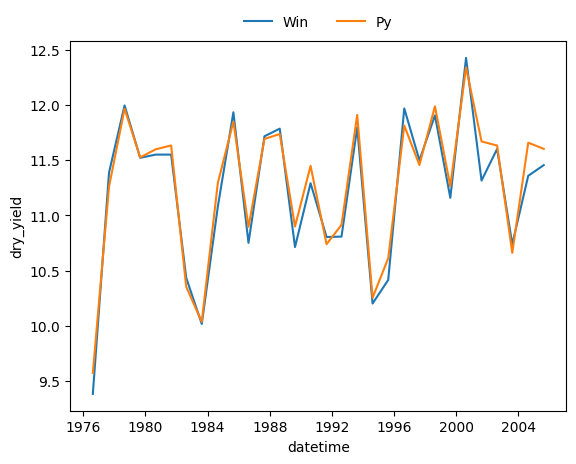

In [ ]:
# Loamy sand soil
loamy_sand = Soil(soil_type='LoamySand')

# crop
potato = Crop('PotatoLocalGDD', planting_date='04/25')

# create model with IrrMethod= Constant depth
model = AquaCropModel(sim_start_time=f'{1976}/03/01',
                      sim_end_time=f'{2005}/12/31',
                      weather_df=brussels_weather,
                      soil=loamy_sand,
                      crop=potato,
                      irrigation_management=IrrigationManagement(irrigation_method=5,),
                      initial_water_content=fc,
                      )
                       

model._initialize()

while model._clock_struct.model_is_finished is False:    
    # get depth to apply, RAW = 36, p_up2 = 0.6 so TAW = 21.6
    depth=get_depth(model,0.216)
    
    model._param_struct.IrrMngt.depth=depth

    model.run_model(initialize_model=False)

run_comparison('Bru_Pot_Irr36RAW2', model)

100% RAW

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_14700\3016353305.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_14700\3016353305.py:56: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


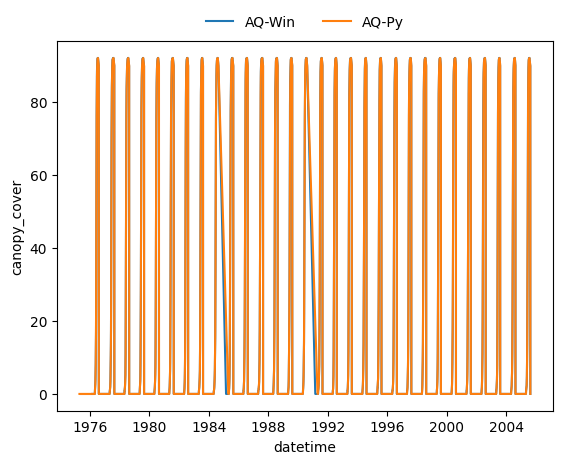

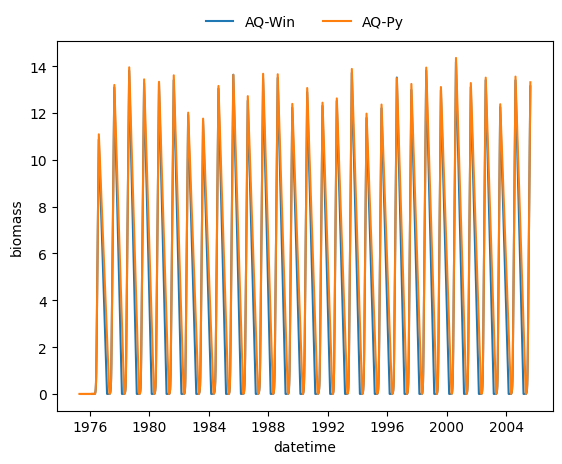

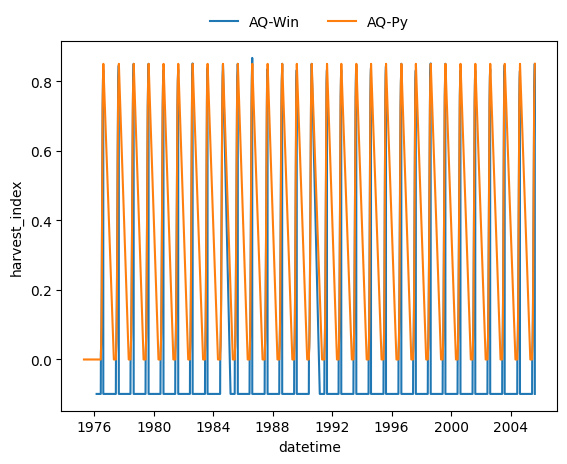

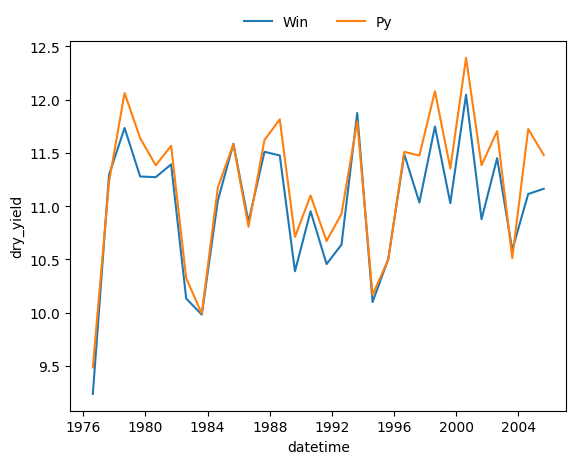

In [ ]:
# create model with IrrMethod= Constant depth
model = AquaCropModel(sim_start_time=f'{1976}/03/01',
                      sim_end_time=f'{2005}/12/31',
                      weather_df=brussels_weather,
                      soil=loamy_sand,
                      crop=potato,
                      irrigation_management=IrrigationManagement(irrigation_method=5,),
                      initial_water_content=fc,
                      )
                       

model._initialize()

while model._clock_struct.model_is_finished is False:    
    # get depth to apply, RAW = 100%, p_up2=0.6, TAW = 60%/0.6
    depth=get_depth(model,0.6)
    
    model._param_struct.IrrMngt.depth=depth

    model.run_model(initialize_model=False)

run_comparison('Bru_Pot_Irr100RAW2', model)

150% RAW

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_14700\3016353305.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_14700\3016353305.py:56: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


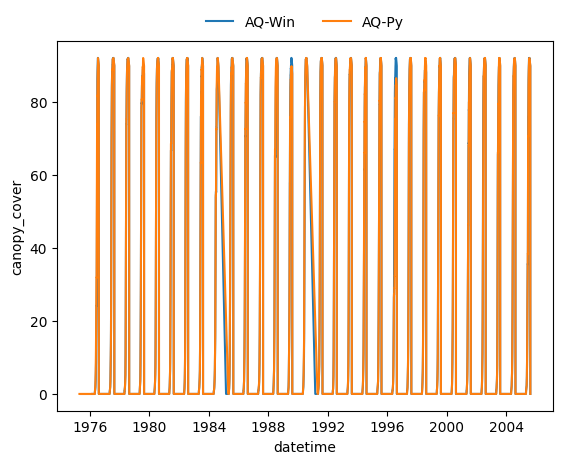

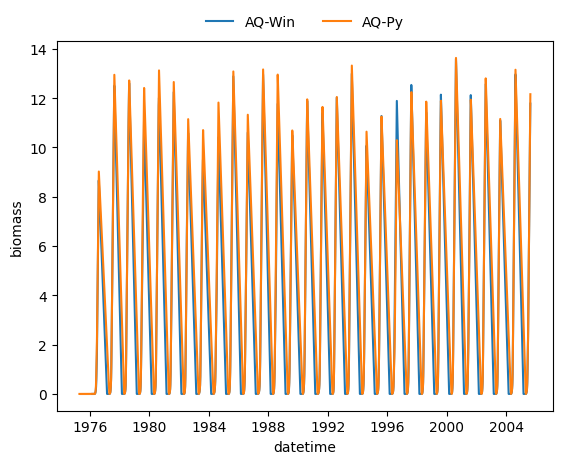

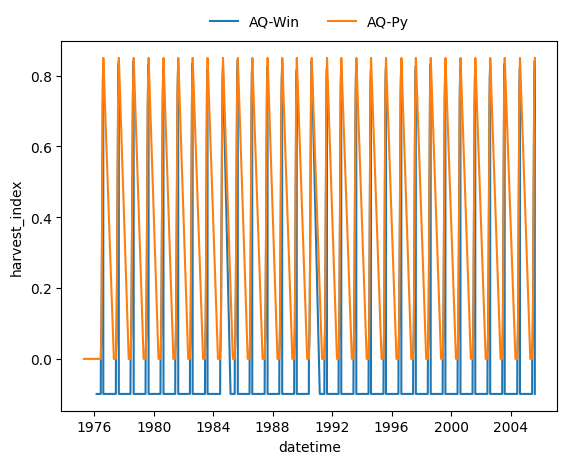

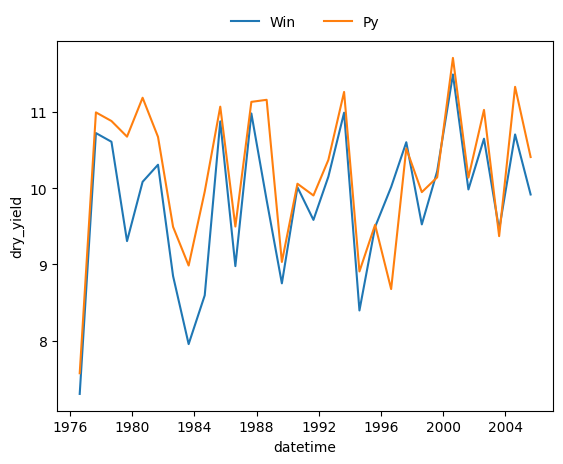

In [ ]:
# create model with IrrMethod= Constant depth
model = AquaCropModel(sim_start_time=f'{1976}/03/01',
                      sim_end_time=f'{2005}/12/31',
                      weather_df=brussels_weather,
                      soil=loamy_sand,
                      crop=potato,
                      irrigation_management=IrrigationManagement(irrigation_method=5,),
                      initial_water_content=fc,
                      )
                       

model._initialize()

while model._clock_struct.model_is_finished is False:    
    # get depth to apply, RAW = 150%, p_up2=0.6, TAW = 90%,0.9
    depth=get_depth(model,0.9)
    
    model._param_struct.IrrMngt.depth=depth

    model.run_model(initialize_model=False)

run_comparison('Bru_Pot_Irr150RAW2', model)

## 9.6 Climate change impact

Historical:

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_14700\3016353305.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_14700\3016353305.py:56: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


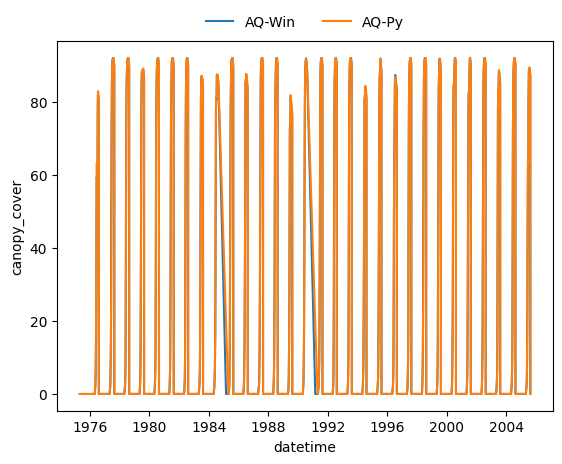

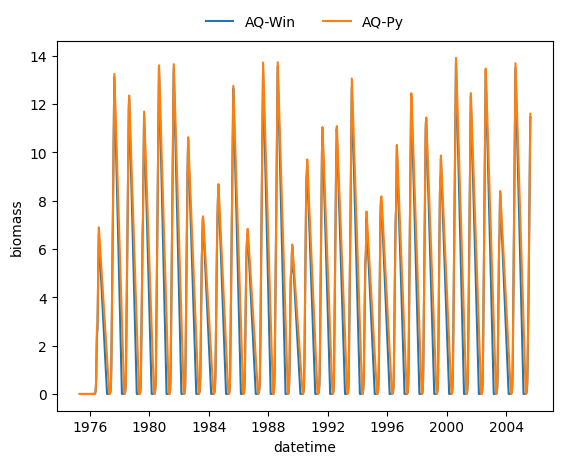

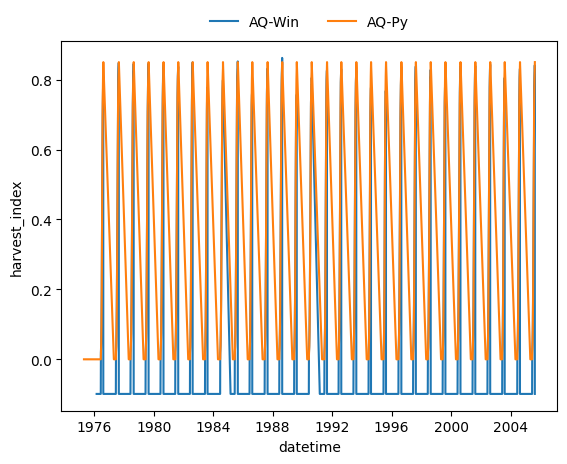

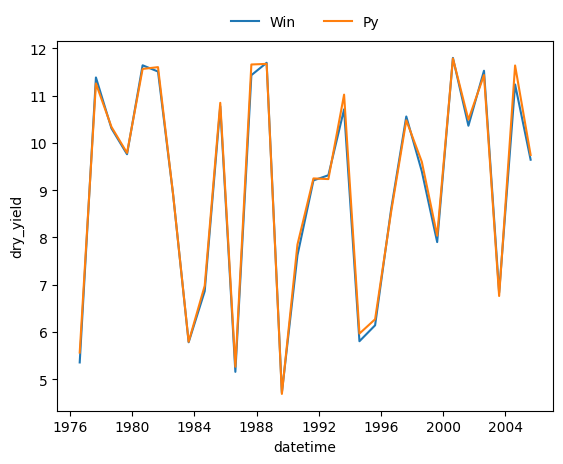

In [ ]:
# Hist climate
filepath=get_filepath('brussels_climate.txt')
brussels_weather = prepare_weather(filepath)

# Local Brussels soil
loam_soil = Soil(soil_type='Loam')

# crops
potato = Crop('PotatoLocalGDD', planting_date='04/25')

# IWC
fc = InitialWaterContent(value=['FC'])

# irr management
irr_mngt = IrrigationManagement(irrigation_method=0)

model = AquaCropModel(sim_start_time=f'{1976}/03/01',
                      sim_end_time=f'{2005}/12/31',
                      weather_df=brussels_weather,
                      soil=loam_soil,
                      crop=potato,
                      irrigation_management=irr_mngt,
                      initial_water_content=fc,
                      )
model.run_model(till_termination=True)

run_comparison('Bru_Pot_Historical', model)

Future:

C:\Users\s10034cb\AppData\Local\Temp\ipykernel_14700\3016353305.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_daily_outputs = pd.read_table('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Crop.OUT',
C:\Users\s10034cb\AppData\Local\Temp\ipykernel_14700\3016353305.py:56: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  win_annual_outputs=pd.read_csv('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/AquaCrop-windows/AquaCropV7.1/OUTP/'+win_filename+'Harvest.OUT',


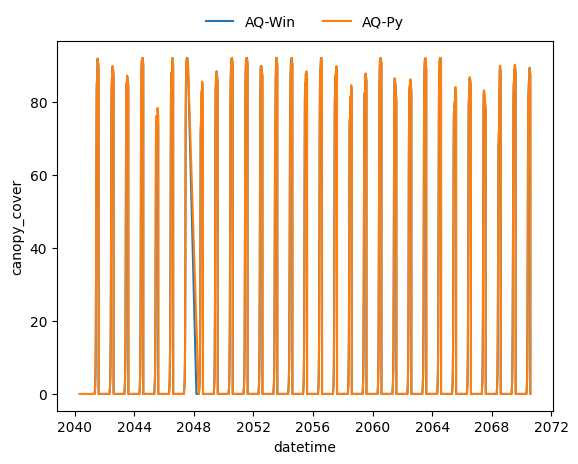

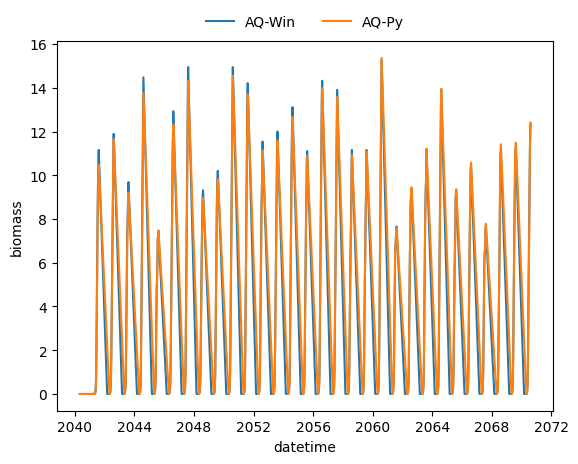

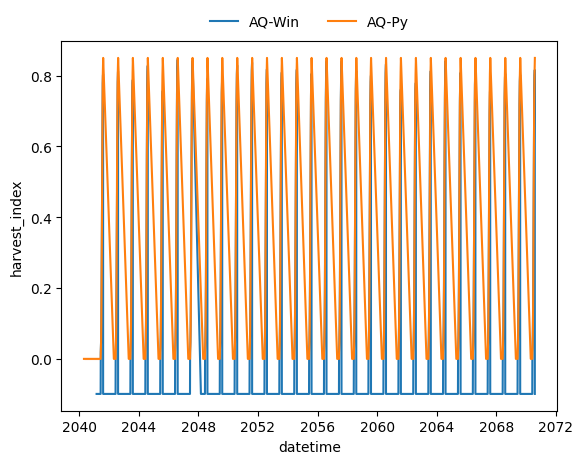

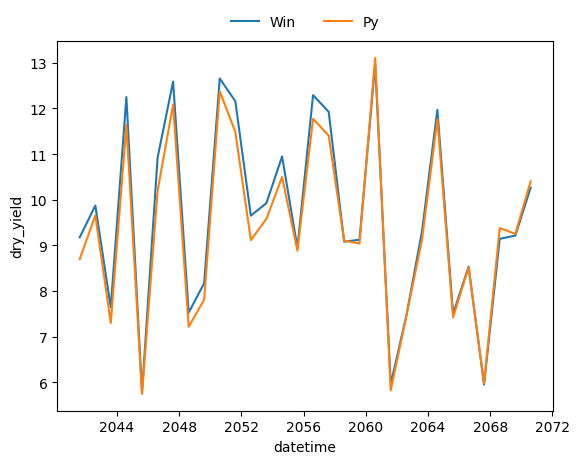

In [ ]:
# Future climate
filepath=get_filepath('C:/Users/s10034cb/Dropbox (The University of Manchester)/Manchester Postdoc/aquacrop/aquacrop/data/brussels_future.txt')
brussels_future = prepare_weather(filepath)

model = AquaCropModel(sim_start_time=f'{2041}/01/01',
                      sim_end_time=f'{2070}/12/31',
                      weather_df=brussels_future,
                      soil=loam_soil,
                      crop=potato,
                      irrigation_management=irr_mngt,
                      initial_water_content=fc,
                      )
model.run_model(till_termination=True)

run_comparison('Bru_Pot_Future_check', model)

### Convert future climate data from AQ-Win formatting for use in AQ-Py

In [ ]:
future_eto=pd.read_csv('../../AquaCrop-windows/AquaCropV7.1/DATA/BrusselsFuture2py.ETo')
future_temp=pd.read_table('../../AquaCrop-windows/AquaCropV7.1/DATA/BrusselsFuture2py.Tnx')
future_precip=pd.read_table('../../AquaCrop-windows/AquaCropV7.1/DATA/BrusselsFuture2py.PLU')

temp=future_eto.join(future_temp)
future_clim=temp.join(future_precip)
future_clim['datetime']=pd.date_range('2041/01/01','2070/12/31')
future_clim['Year']=pd.DatetimeIndex(future_clim['datetime']).year
future_clim['Month']=pd.DatetimeIndex(future_clim['datetime']).month
future_clim['Day']=pd.DatetimeIndex(future_clim['datetime']).day

future_clim.rename(columns={
    'Tmin (C)' : 'Tmin(C)',
    'TMax (C)' : 'Tmax(C)',
    'Average ETo (mm/day)' : 'Et0(mm)',
    'Total Rain (mm)' : 'Prcp(mm)'
},
inplace=True    
)

print(future_clim)

future_clim.drop('datetime',axis=1,inplace=True)
col_order=['Day', 'Month','Year','Tmin(C)','Tmax(C)','Prcp(mm)','Et0(mm)']
future_clim=future_clim[col_order]

future_clim.to_csv('brussels_future.txt', sep='\t')

print(future_clim)


       Et0(mm)  Tmin(C)  Tmax(C)  Prcp(mm)   datetime  Year  Month  Day
0          0.4      2.5      8.5       0.0 2041-01-01  2041      1    1
1          0.2      0.2      6.3       0.0 2041-01-02  2041      1    2
2          0.6     -1.4      7.9       0.0 2041-01-03  2041      1    3
3          0.5     -3.0      3.9       0.0 2041-01-04  2041      1    4
4          1.1    -10.6      6.1       0.0 2041-01-05  2041      1    5
...        ...      ...      ...       ...        ...   ...    ...  ...
10952      0.6      6.0     11.9       9.7 2070-12-27  2070     12   27
10953      0.4      0.4      8.3       0.0 2070-12-28  2070     12   28
10954      0.4      2.0      6.8       0.0 2070-12-29  2070     12   29
10955      0.3     -0.8      3.7       0.0 2070-12-30  2070     12   30
10956      0.3      3.3      6.6       0.0 2070-12-31  2070     12   31

[10957 rows x 8 columns]
       Day  Month  Year  Tmin(C)  Tmax(C)  Prcp(mm)  Et0(mm)
0        1      1  2041      2.5      8.5       0